In [103]:
# 한글폰트
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
!apt-get update -qq
!apt-get install fonte-nanum* -qq

import matplotlib.font_manager as fm
fm._rebuild()

# 한글 폰트 확인하기
for fontInfo in fm.fontManager.ttflist:
  if 'Nanum' in fontInfo.name:
    print(fontInfo.name + ' = '+fontInfo.fname)

plt.rc('font', family = 'NanumGothic')

# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

E: Unable to locate package fonte-nanum*
E: Couldn't find any package by glob 'fonte-nanum*'
E: Couldn't find any package by regex 'fonte-nanum*'
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothic.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf


In [104]:
# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


# 데이터 불러오기
train = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
val = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_자율평가데이터.xlsx')
test = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_평가데이터_update_210831.xlsx')

In [105]:
# train과 val 합쳐주기
df = pd.concat([train, val], axis = 0)

# column 편하게 바꿔주기
df = df.rename(columns = {'REG_DATE':'기준일', 'P_TYPE':'제품구분','CTRY_1':'제조국','CTRY_2':'수출국',
                        'P_PURPOSE':'수입용도','CATEGORY_1':'중분류명 카테고리',
                        'CATEGORY_2':'어종','P_NAME':'상세어종','P_IMPORT_TYPE':'수입형태',
                        'P_PRICE':'target'})

train = train.rename(columns= {'REG_DATE':'기준일', 'P_TYPE':'제품구분','CTRY_1':'제조국','CTRY_2':'수출국',
                        'P_PURPOSE':'수입용도','CATEGORY_1':'중분류명 카테고리',
                        'CATEGORY_2':'어종','P_NAME':'상세어종','P_IMPORT_TYPE':'수입형태',
                        'P_PRICE':'target'})

val = val.rename(columns= {'REG_DATE':'기준일', 'P_TYPE':'제품구분','CTRY_1':'제조국','CTRY_2':'수출국',
                        'P_PURPOSE':'수입용도','CATEGORY_1':'중분류명 카테고리',
                        'CATEGORY_2':'어종','P_NAME':'상세어종','P_IMPORT_TYPE':'수입형태',
                        'P_PRICE':'target'})

In [106]:
# 데이터에서 상세어종이 연어인 데이터만 뽑아내기
df = df[df['상세어종'] == '연어']
train = train[train['상세어종'] == '연어']
val = val[val['상세어종'] == '연어']

# 연어만 뽑아 냈기 때문에 index를 다시 설정해 준다.
df = df.reset_index(drop = True)
train = train.reset_index(drop = True)
val = val.reset_index(drop = True)

# 데이터 EDA

## 이상치 제거

Text(0.5, 1.0, 'target의 밀도분포 확인')

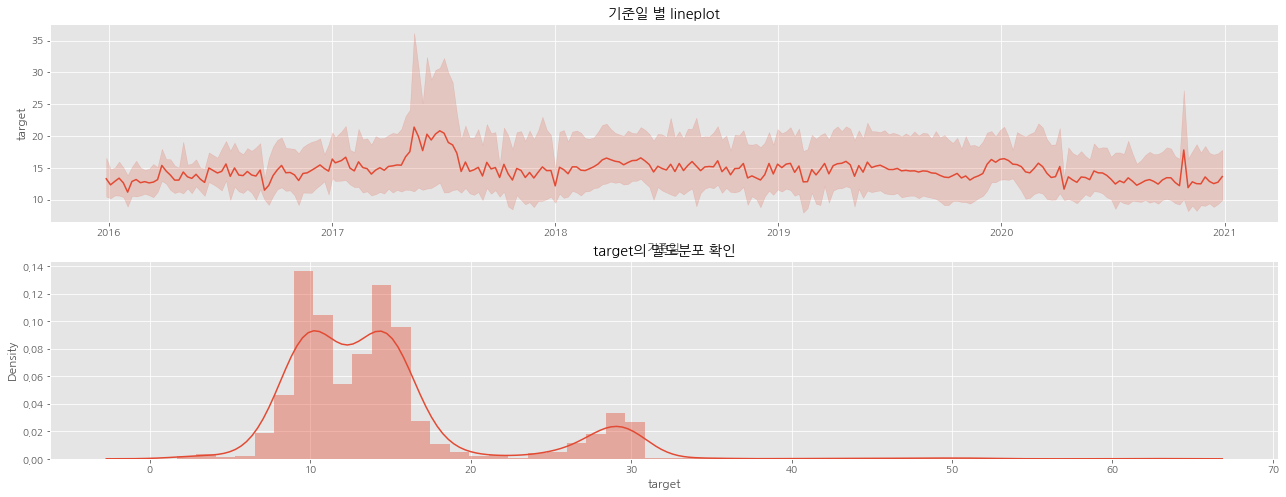

In [107]:
# lineplot으로 데이터의 큰 이상치들을 제거해 주도록 하자.
fig, ax = plt.subplots(nrows = 2, figsize = (22,8))
sns.lineplot(data = df, x = '기준일', y = 'target', ax = ax[0])
sns.distplot(df['target'], ax = ax[1])
ax[0].set_title('기준일 별 lineplot')
ax[1].set_title('target의 밀도분포 확인')

In [108]:
# 시간별 데이터로 column 만들어 주기
def time_column(data = None, column = None):
  data['year'] = data[column].dt.year
  data['month'] = data[column].dt.month
  data['week'] = data[column].dt.week
  data['day'] = data[column].dt.day

  return data

# 데이터의 시간 column들 만들어 주기.
df = time_column(df, column = '기준일')
train = time_column(train, column = '기준일')
val = time_column(val, column = '기준일')

In [109]:
#  이상치 제거를 IQR 방법을 통해서 제거해 보도록 하자.
def get_outlier(df=None, column=None, weight=3.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

######################### train ################################################
# 가중치를 4.0으로 이상치 제거해주기
delete_index = get_outlier(df = train, column = 'target', weight = 4.0)
print(train.loc[delete_index, :])

# index를 찾아서 전부 nan값으로 변경해준다.
for i in delete_index:
  train.loc[i,'target'] = np.nan

# 결측치 채우는 방식을 interpolation을 사용한다면?
train[(train['제조국'] == '노르웨이') & (train['수입용도'] == '자사제품제조용') & (train['수입형태'] == '냉장,필렛(F)')] = train[(train['제조국'] == '노르웨이') & (train['수입용도'] == '자사제품제조용') & (train['수입형태'] == '냉장,필렛(F)')].interpolate()

print('결측치를 채운 이후 :',train.isnull().sum().sum())
########################### df #################################################
delete_index = get_outlier(df = df, column = 'target', weight = 4.0)
print(df.loc[delete_index, :])

# index를 찾아서 전부 nan값으로 변경해준다.
for i in delete_index:
  df.loc[i,'target'] = np.nan

df[(df['제조국'] == '노르웨이') & (df['수입용도'] == '자사제품제조용') & (df['수입형태'] == '냉장,필렛(F)')] = df[(df['제조국'] == '노르웨이') & (df['수입용도'] == '자사제품제조용') & (df['수입형태'] == '냉장,필렛(F)')].interpolate()

print('결측치를 채운 이후 :',df.isnull().sum().sum())


           기준일 제품구분   제조국   수출국     수입용도  ...     target  year month week  day
530 2017-05-15  수산물  노르웨이  노르웨이  자사제품제조용  ...  62.457202  2017     5   20   15
537 2017-05-22  수산물  노르웨이  노르웨이  자사제품제조용  ...  49.777500  2017     5   21   22
545 2017-05-29  수산물  노르웨이  노르웨이  자사제품제조용  ...  40.521693  2017     5   22   29
552 2017-06-05  수산물  노르웨이  노르웨이  자사제품제조용  ...  51.394008  2017     6   23    5
559 2017-06-12  수산물  노르웨이  노르웨이  자사제품제조용  ...  43.791678  2017     6   24   12
566 2017-06-19  수산물  노르웨이  노르웨이  자사제품제조용  ...  48.550884  2017     6   25   19
572 2017-06-26  수산물  노르웨이  노르웨이  자사제품제조용  ...  43.481666  2017     6   26   26
579 2017-07-03  수산물  노르웨이  노르웨이  자사제품제조용  ...  50.173407  2017     7   27    3
587 2017-07-10  수산물  노르웨이  노르웨이  자사제품제조용  ...  52.263797  2017     7   28   10
595 2017-07-17  수산물  노르웨이  노르웨이  자사제품제조용  ...  47.185995  2017     7   29   17

[10 rows x 14 columns]
결측치를 채운 이후 : 0
            기준일 제품구분   제조국   수출국     수입용도  ...     target  year month week  day
530  2017-05

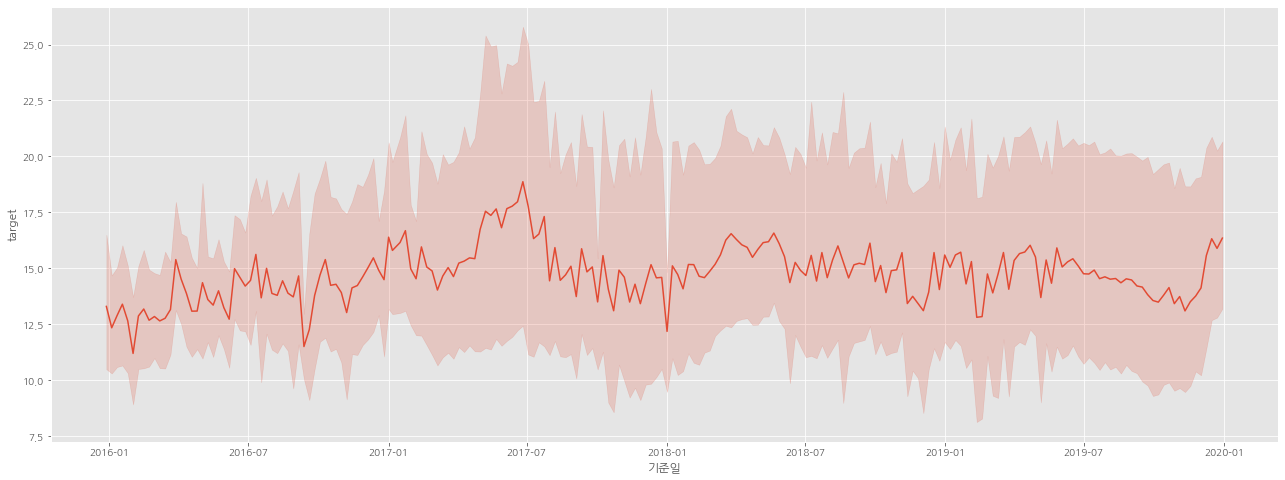

In [110]:
plt.figure(figsize = (22,8))
sns.lineplot(data = train, x= '기준일', y = 'target')

Text(0.5, 0, '')

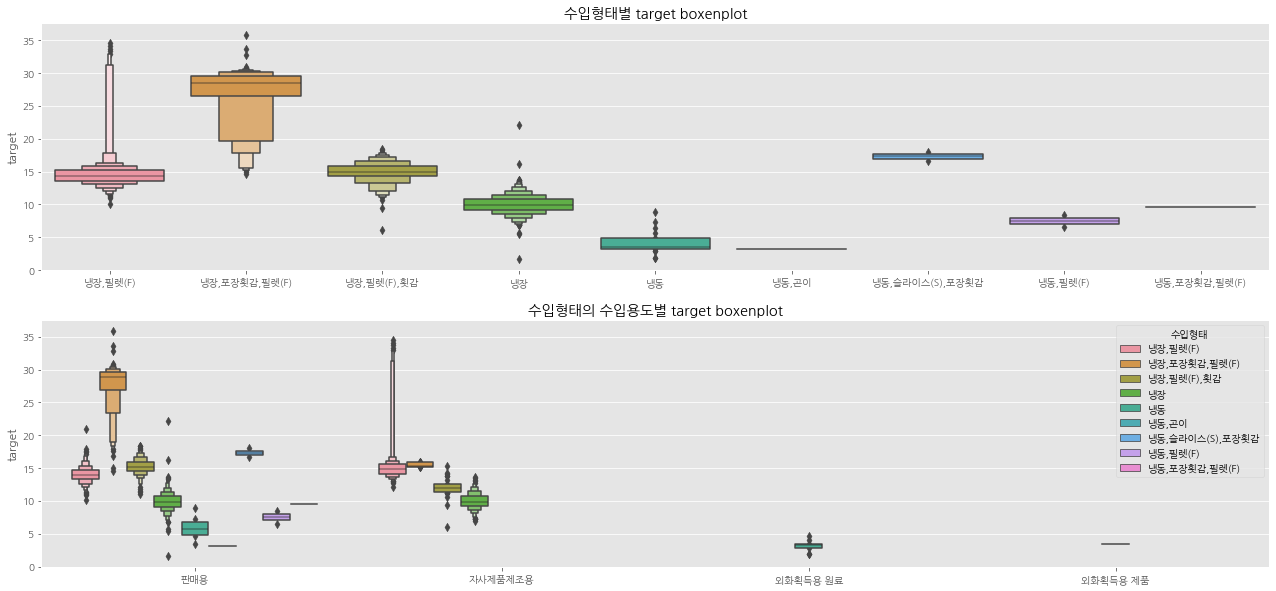

In [111]:
# 각 가격별 데이터를 확인해 보자.
fig, ax = plt.subplots(nrows = 2, figsize = (22,10))
sns.boxenplot(data = df, x = '수입형태', y = 'target', ax = ax[0])
# 수입용도의 평균가격을 수입형태 기준으로 살펴보자.
sns.boxenplot(data = df, x = '수입용도', y = 'target', hue = '수입형태', ax = ax[1])

ax[0].set_title('수입형태별 target boxenplot')
ax[1].set_title('수입형태의 수입용도별 target boxenplot')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

In [112]:
################################################ train ################################################
# 위의 그래프를 보면 IQR을 적용시켜 줄 때 수입형태별 수입용도를 기준으로 IQR을 시켜주도록 하자.
for i in train['수입형태'].unique():
  for j in train['수입용도'].unique():
    try:
      delete_index = get_outlier(train[(train['수입형태'] == i) & (train['수입용도'] == j)], column  = 'target', weight = 3.5)

      if len(delete_index) > 0:

        print(f'수입형태 : {i},  수입용도 : {j}, 제거되는 index : {delete_index}')

        train.loc[delete_index, 'target'] = np.nan

        # for k in train.index:
        #   if k in delete_index:

        #     train.loc[k, 'target'] = train[(train['month'] == train.loc[k,'month']) & (train['수입용도'] == train.loc[k,'수입용도']) & (train['제조국'] == train.loc[k,'제조국'])]['target'].mean()

        train[(train['수입형태'] == i) & (train['수입용도'] == j)] = train[(train['수입형태'] == i) & (train['수입용도'] == j)].interpolate()
      
    except:
      pass

# 그러면 칠레의 데이터가 채워지지 않으므로 제거해준다.
print(train[train['target'].isnull()])

################################################ df ################################################
# 수입형태별 수입용도를 기준으로 IQR을 시켜주도록 하자.
for i in df['수입형태'].unique():
  for j in df['수입용도'].unique():
    try:
      delete_index = get_outlier(df[(df['수입형태'] == i) & (df['수입용도'] == j)], column  = 'target', weight = 3.5)

      if len(delete_index) > 0:

        print(f'수입형태 : {i},  수입용도 : {j}, 제거되는 index : {delete_index}')

        df.loc[delete_index, 'target'] = np.nan

        # for k in train.index:
        #   if k in delete_index:

        #     train.loc[k, 'target'] = train[(train['month'] == train.loc[k,'month']) & (train['수입용도'] == train.loc[k,'수입용도']) & (train['제조국'] == train.loc[k,'제조국'])]['target'].mean()

        df[(df['수입형태'] == i) & (df['수입용도'] == j)] = df[(df['수입형태'] == i) & (df['수입용도'] == j)].interpolate()
      
    except:
      pass

print(df[df['target'].isnull()])

수입형태 : 냉장,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([1462], dtype='int64')
수입형태 : 냉장,필렛(F),  수입용도 : 자사제품제조용, 제거되는 index : Int64Index([313, 516, 523, 530, 537, 545, 552, 559, 566, 572, 579, 587, 595,
            602, 1471],
           dtype='int64')
수입형태 : 냉장,포장횟감,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([15, 39, 52, 60, 84, 135, 157, 488], dtype='int64')
수입형태 : 냉장,필렛(F),횟감,  수입용도 : 자사제품제조용, 제거되는 index : Int64Index([31], dtype='int64')
수입형태 : 냉장,  수입용도 : 판매용, 제거되는 index : Int64Index([91, 98, 212], dtype='int64')
Empty DataFrame
Columns: [기준일, 제품구분, 제조국, 수출국, 수입용도, 중분류명 카테고리, 어종, 상세어종, 수입형태, target, year, month, week, day]
Index: []
수입형태 : 냉장,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([1462], dtype='int64')
수입형태 : 냉장,필렛(F),  수입용도 : 자사제품제조용, 제거되는 index : Int64Index([313, 516, 523, 530, 537, 545, 552, 559, 566, 572, 579, 587, 595,
            602, 1471],
           dtype='int64')
수입형태 : 냉장,포장횟감,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([15, 39, 60, 488], dtype='int64')
수입형태 : 냉장,필렛

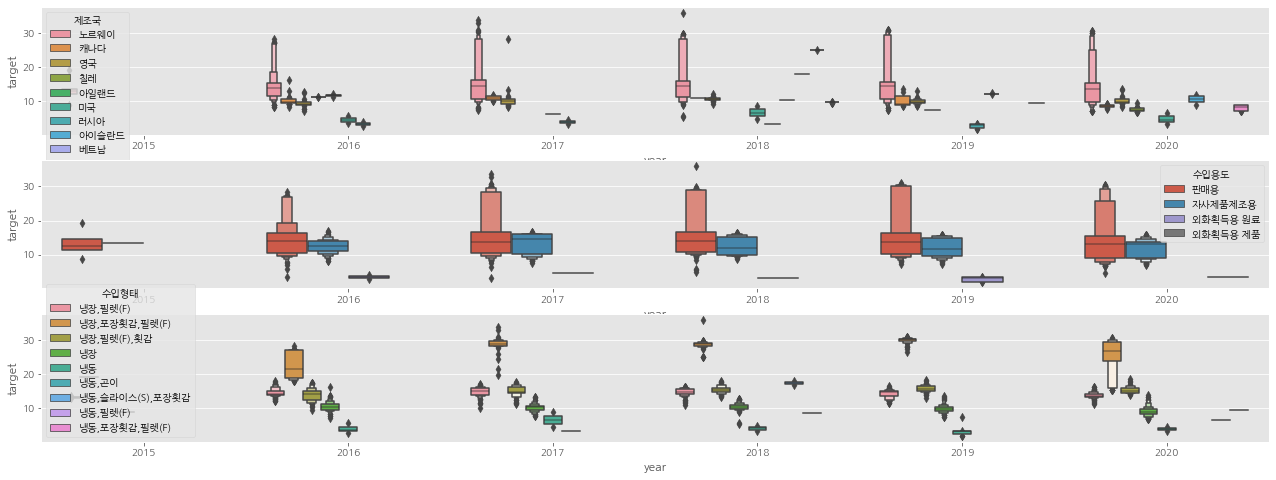

In [113]:
# 연별로 데이터의 이상치를 확인해 보자.
fig, ax = plt.subplots(nrows = 3, figsize = (22,8))
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '제조국', ax = ax[0])
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '수입용도', ax = ax[1])
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '수입형태', ax = ax[2])

## 데이터 전처리

In [114]:
# 냉동이라는 부분은 얼마 없다고 판단한다.
# 그러면 냉동의 데이터를 하나의 변수로 묶어주기로 하자.
for i in df.index:
  if df.loc[i, '수입형태'][:2] == '냉동':
    df.loc[i,'수입형태'] = '냉동'

for i in train.index:
  if train.loc[i, '수입형태'][:2] == '냉동':
    train.loc[i,'수입형태'] = '냉동'

for i in val.index:
  if val.loc[i, '수입형태'][:2] == '냉동':
    val.loc[i,'수입형태'] = '냉동'

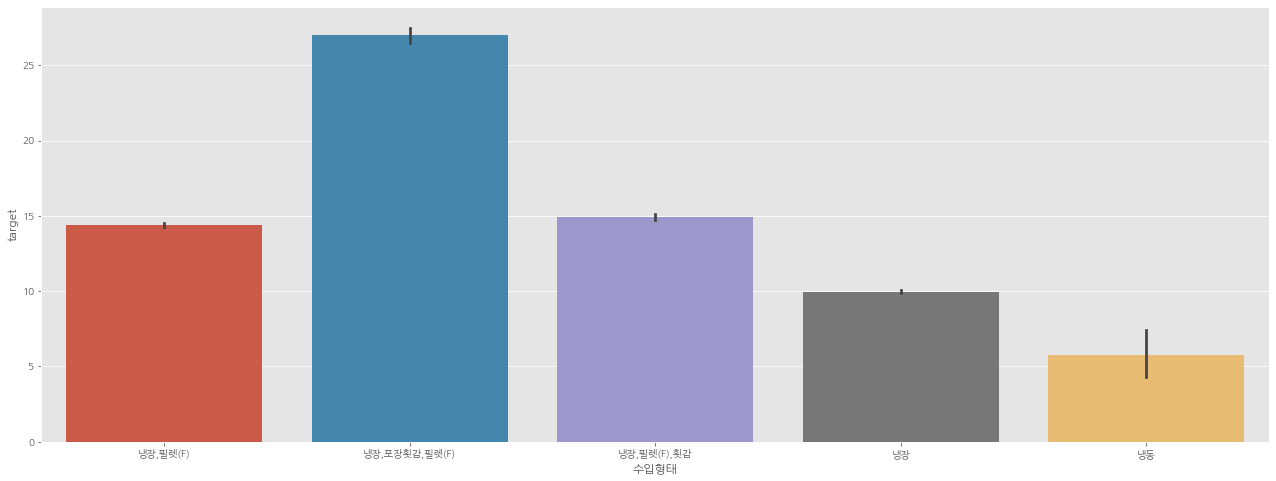

In [115]:
# 수입형태가 잘 바뀌었는지 확인해 본다.
plt.figure(figsize = (22,8))
sns.barplot(data = df, x = '수입형태', y = 'target')

In [116]:
def new_column(df = None):

  연어_수입형태 = set()

  for index in df.index:
    value_list = df.loc[index, '수입형태'].split(',')
    
    연어_수입형태.update(value_list)

  # 고유한 수입형태에 모두 0 넣어주기
  df[list(연어_수입형태)] = 0

  for index in df.index:
    value_list = df.loc[index, '수입형태'].split(',')
    
    for value in value_list:
      df.loc[index, value] = 1

  return df

df = new_column(df = df)
train = new_column(df= train)
val = new_column(df = val)

In [117]:
# 필요없는 변수들을 전부 제거해준다.
df.drop(['제품구분','중분류명 카테고리','어종','상세어종'], axis = 1, inplace = True)
train.drop(['제품구분','중분류명 카테고리','어종','상세어종'], axis = 1, inplace = True)
val.drop(['제품구분','중분류명 카테고리','어종','상세어종'], axis = 1, inplace = True)

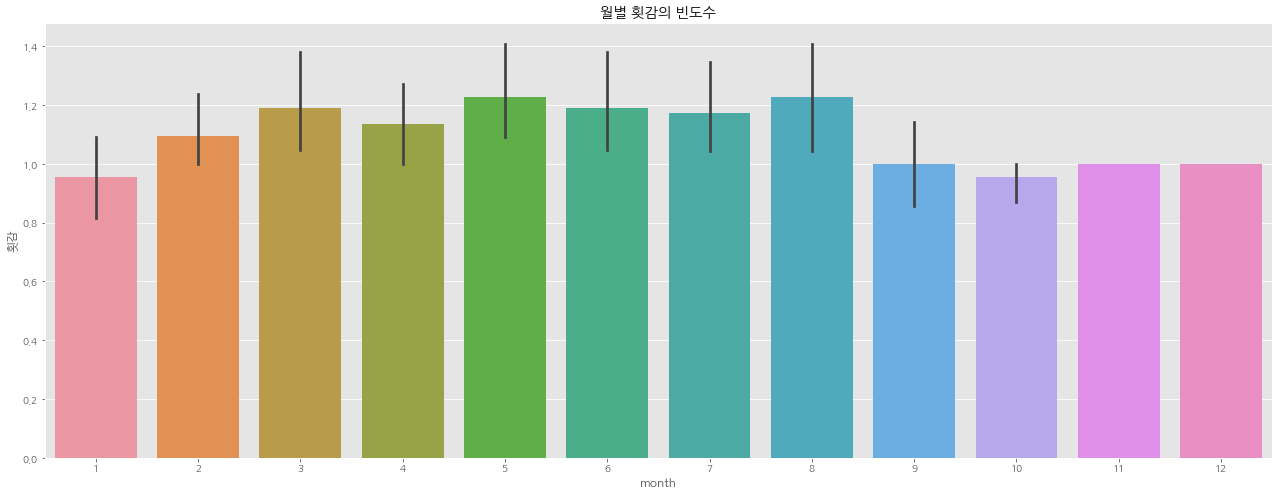

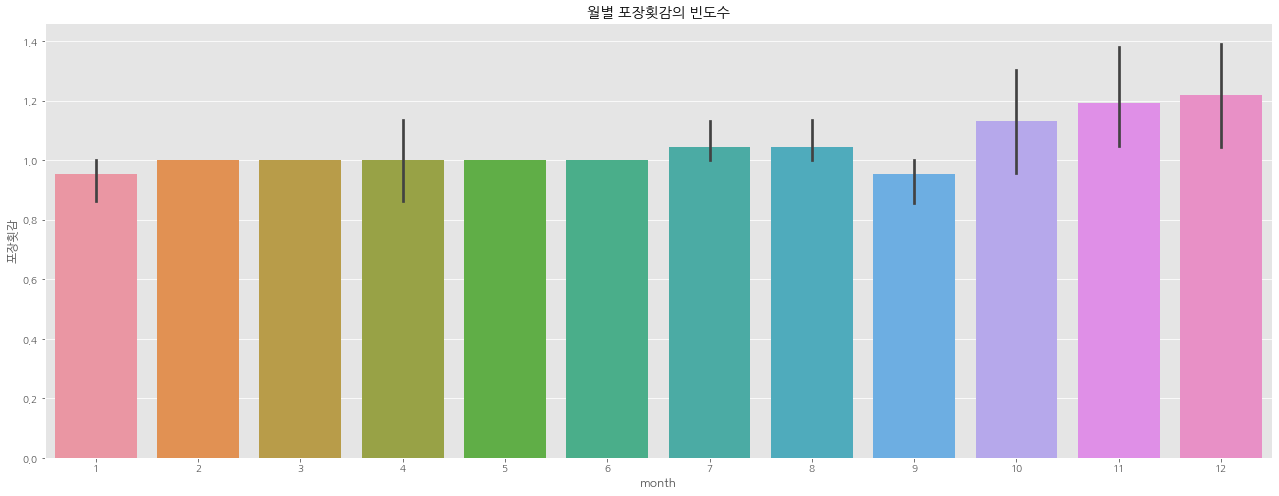

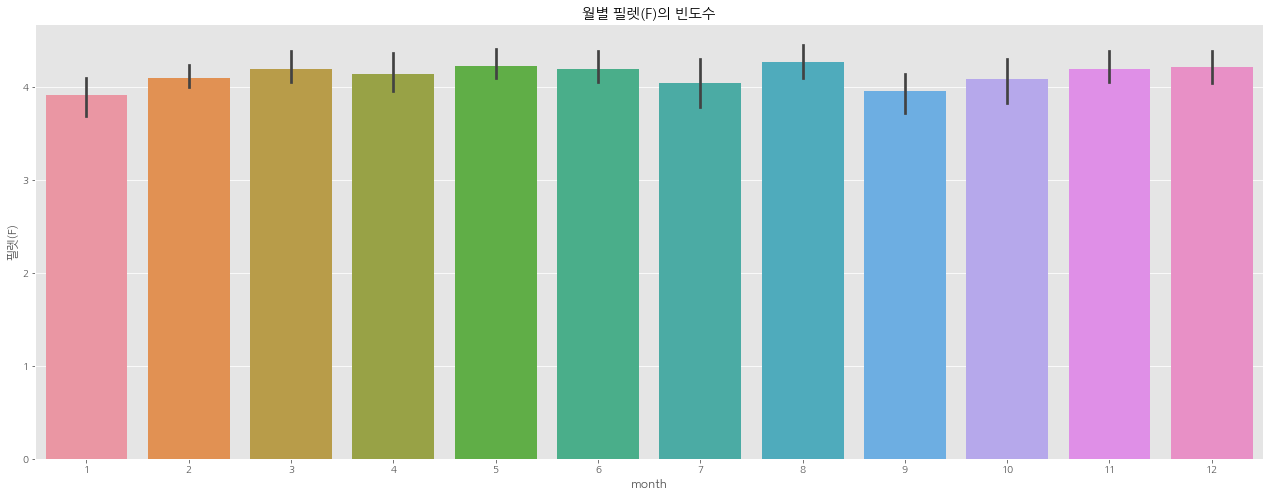

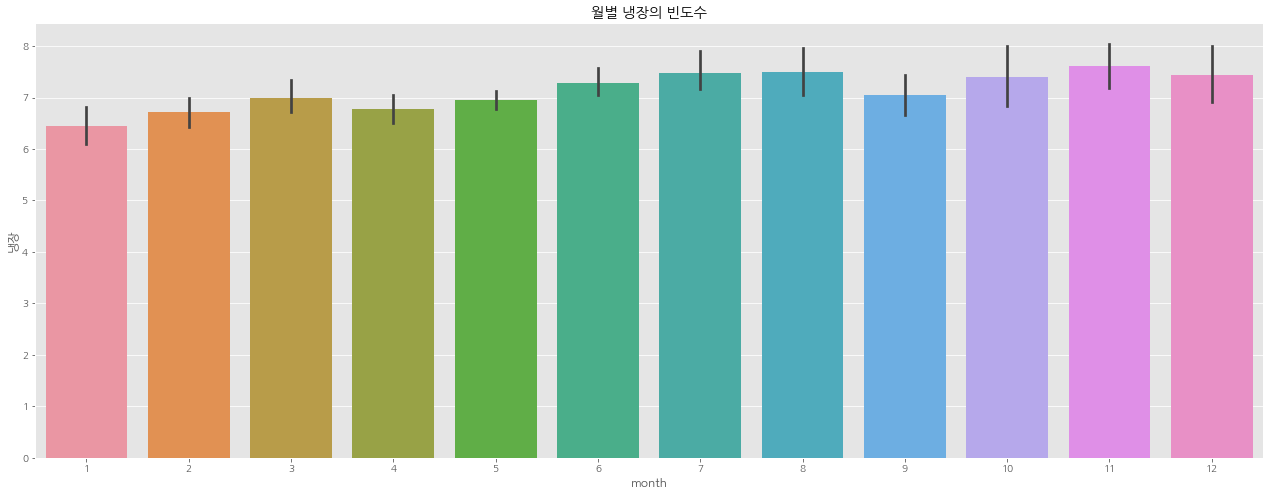

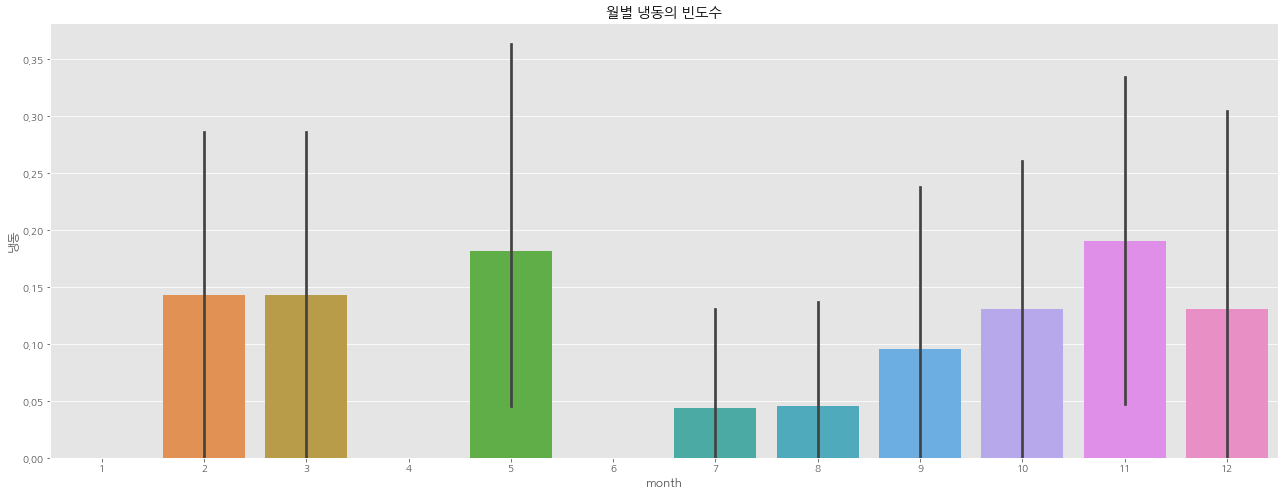

In [118]:
split_수입형태 = df.groupby('기준일')[['횟감'	,'포장횟감'	,'필렛(F)'	,'냉장'	,'냉동']].sum().reset_index()

split_수입형태['year'] = split_수입형태['기준일'].dt.year
split_수입형태['month'] = split_수입형태['기준일'].dt.month
split_수입형태['day'] = split_수입형태['기준일'].dt.day
split_수입형태['week'] = split_수입형태['기준일'].dt.week

target_mean = df.groupby('기준일')['target'].mean().reset_index()

for i in ['횟감'	,'포장횟감'		,'필렛(F)'	,'냉장'	,'냉동']:
  plt.figure(figsize = (22,8))
  sns.barplot(data = split_수입형태, x = 'month', y = i)
  plt.title(f'월별 {i}의 빈도수')
  plt.show()

Text(0.5, 1.0, 'month of target mean')

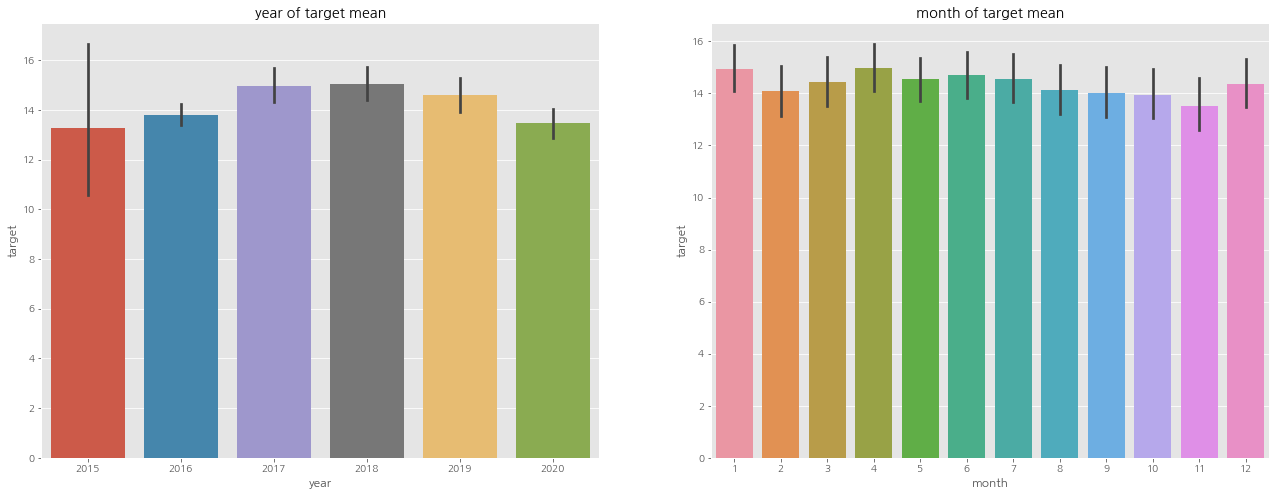

In [119]:
# year, month
fig, ax = plt.subplots(ncols = 2, figsize=  (22,8))
sns.barplot(data = df, x = 'year', y = 'target', ax = ax[0])
sns.barplot(data = df, x = 'month', y = 'target', ax = ax[1])
ax[0].set_title('year of target mean')
ax[1].set_title('month of target mean')

Text(0.5, 1.0, 'week of target mean')

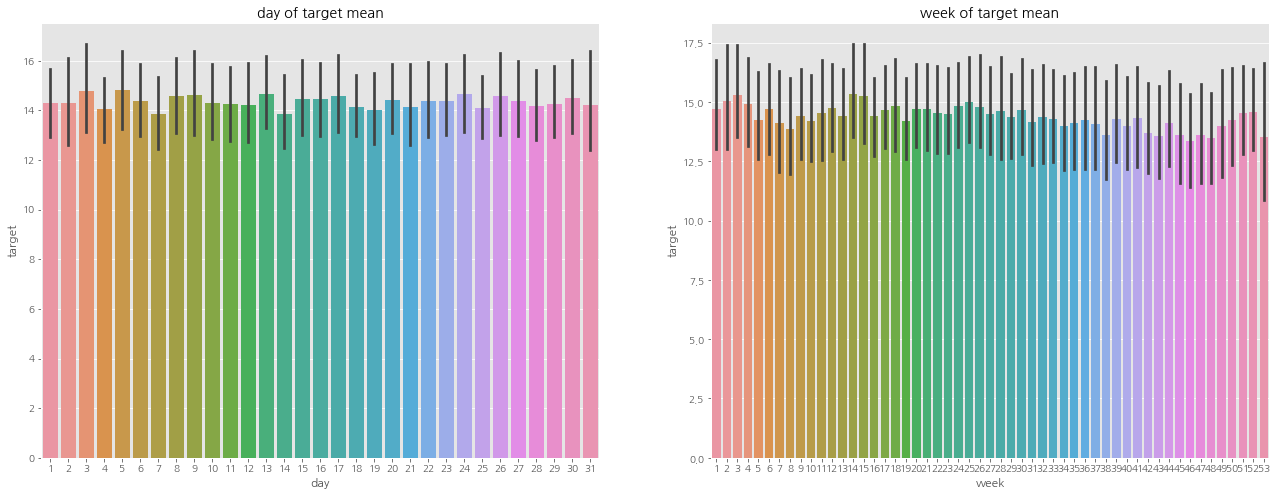

In [120]:
# day, week
fig, ax = plt.subplots(ncols = 2, figsize = (22,8))
sns.barplot(data = df, x = 'day', y = 'target', ax = ax[0])
sns.barplot(data = df, x = 'week', y = 'target', ax = ax[1])
ax[0].set_title('day of target mean')
ax[1].set_title('week of target mean')

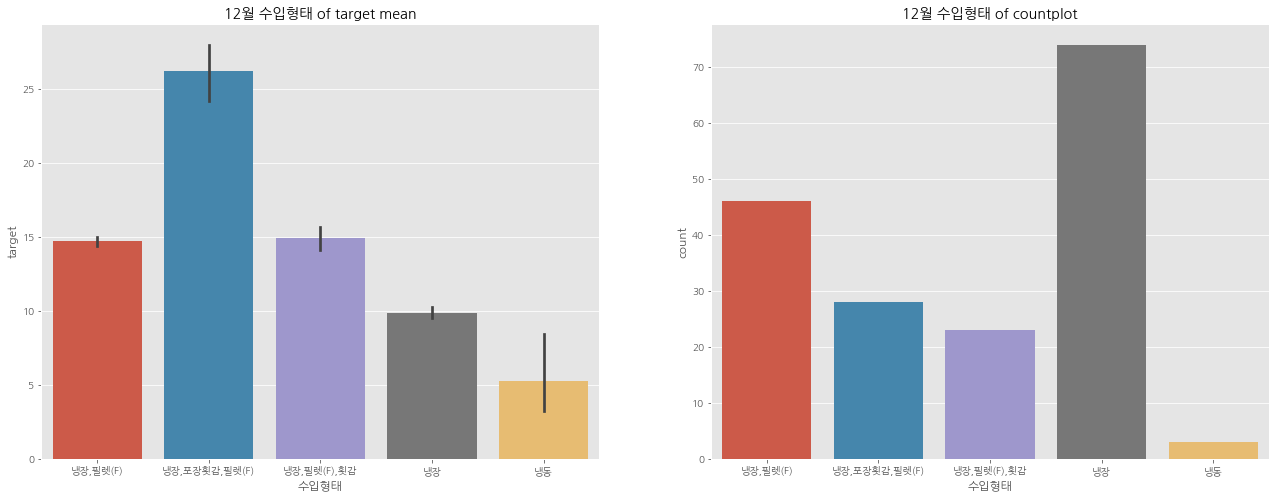

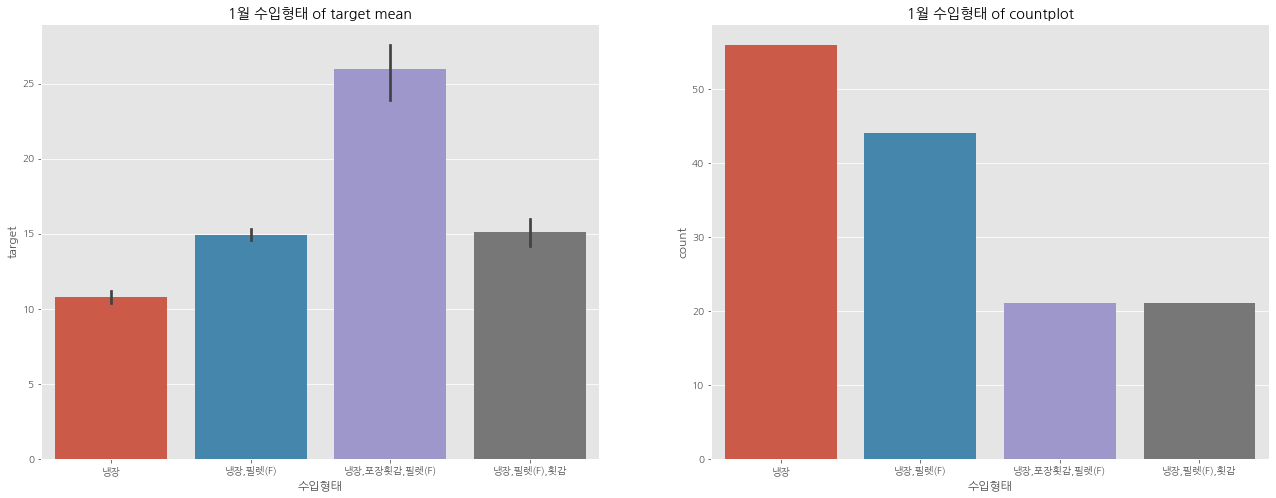

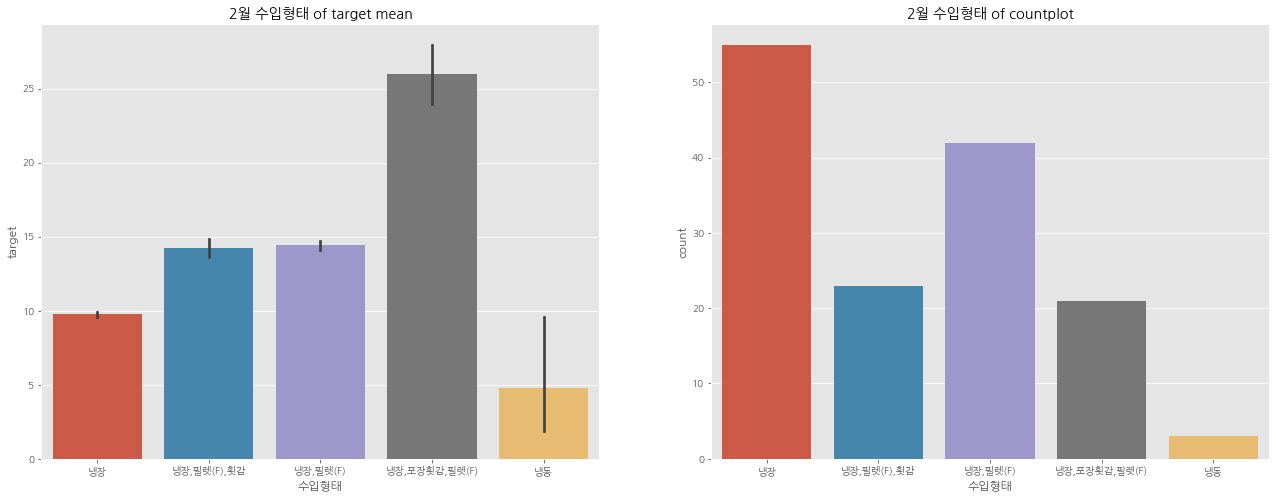

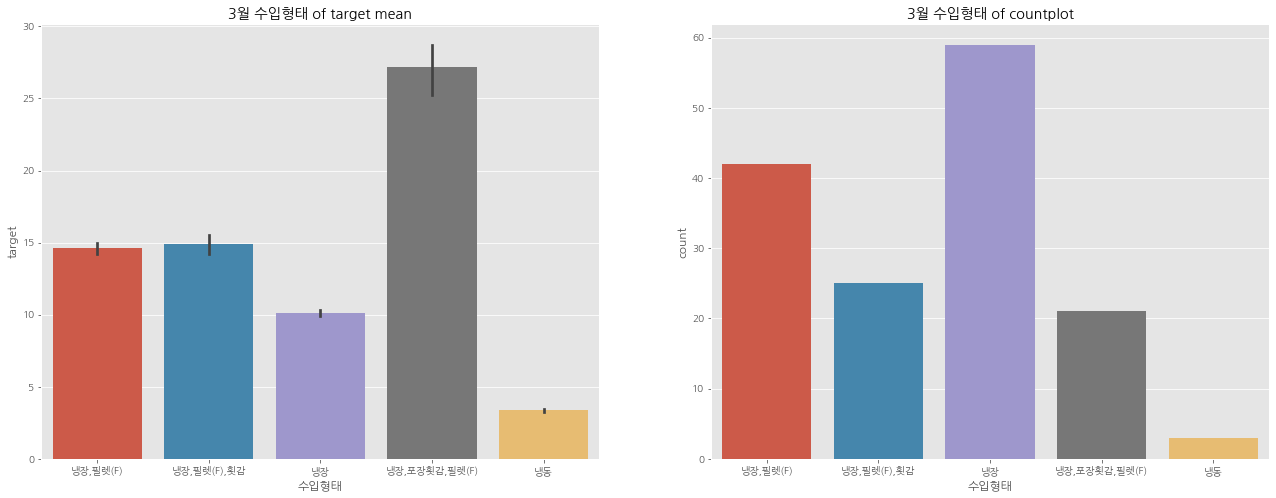

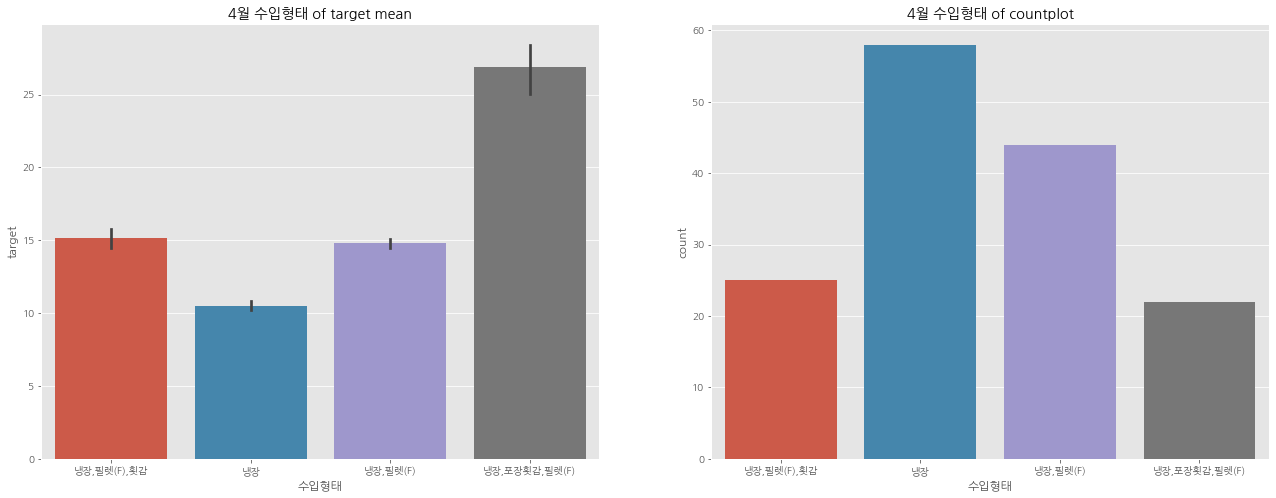

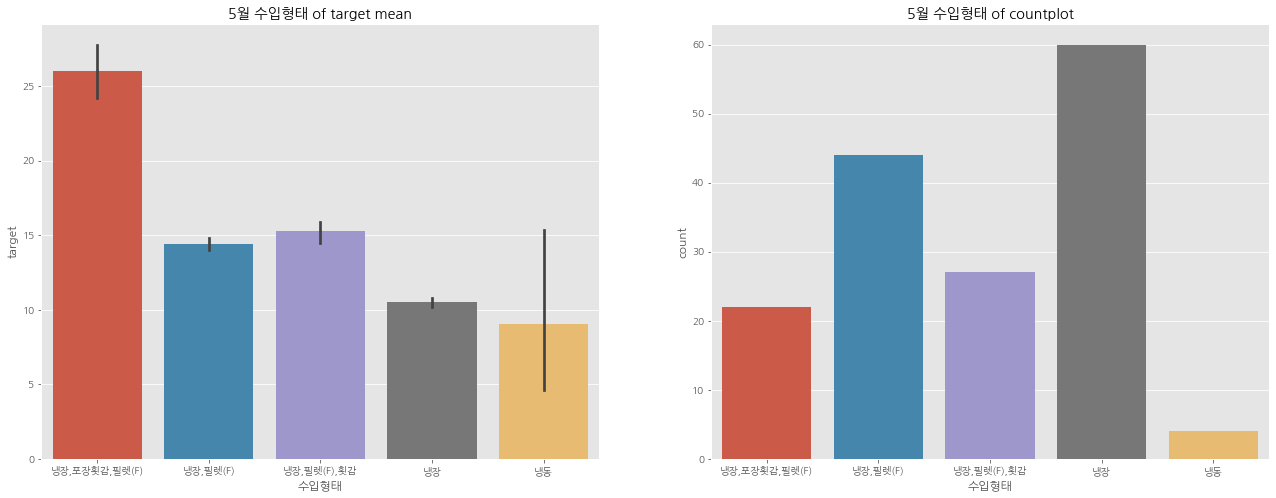

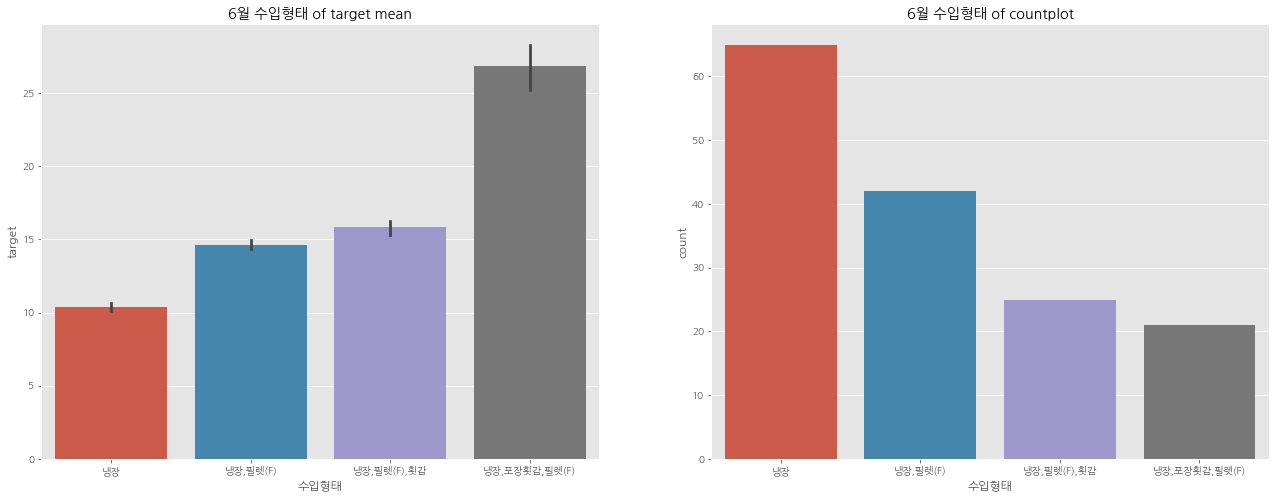

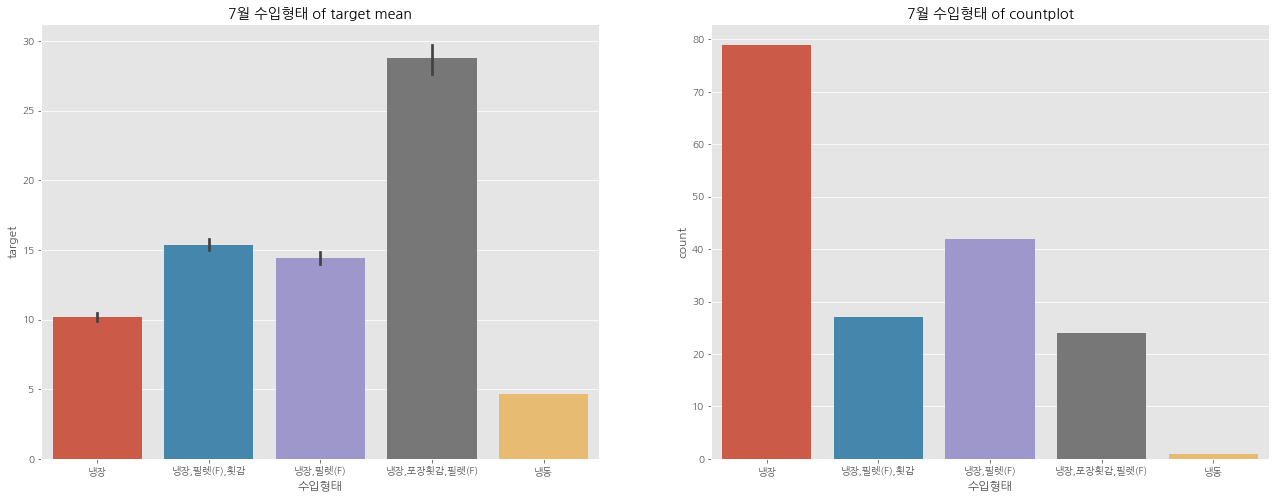

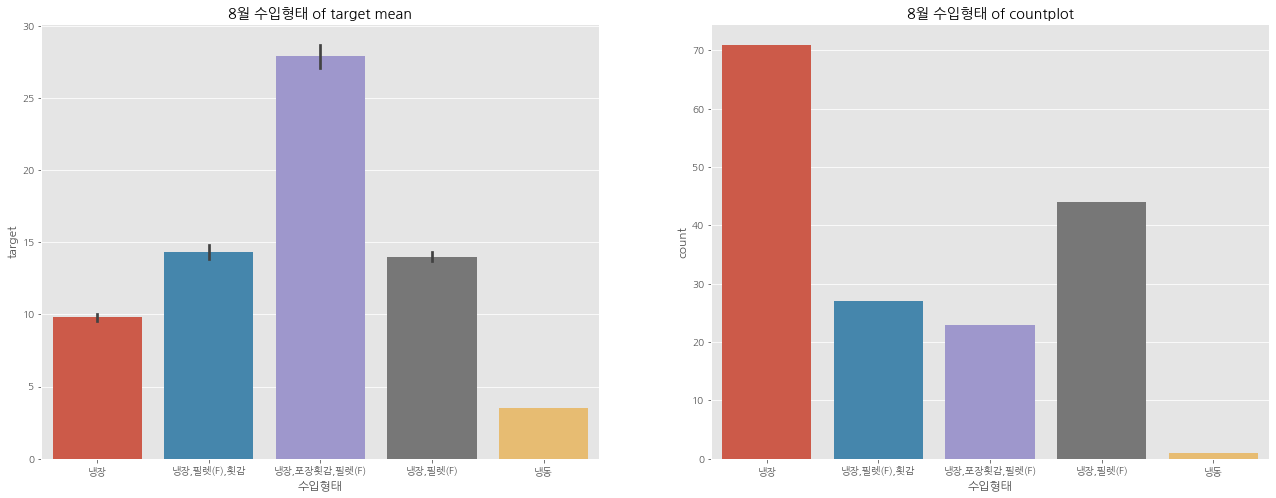

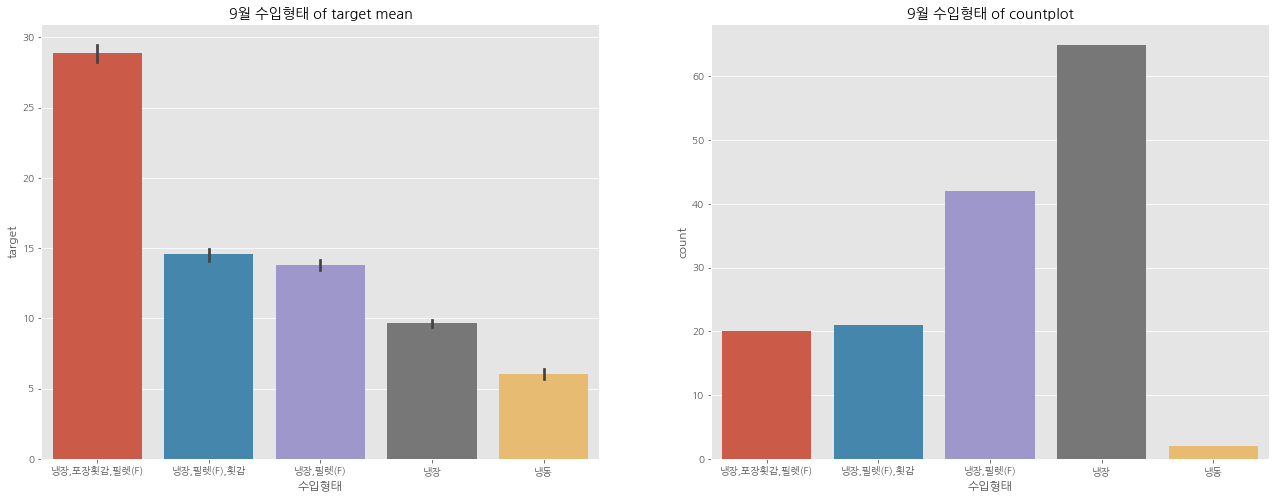

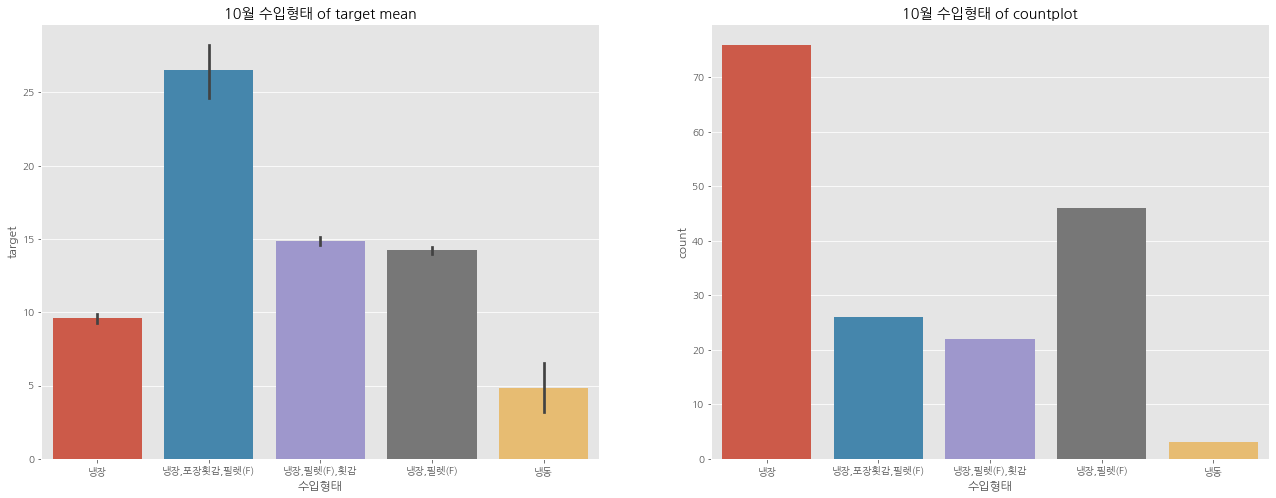

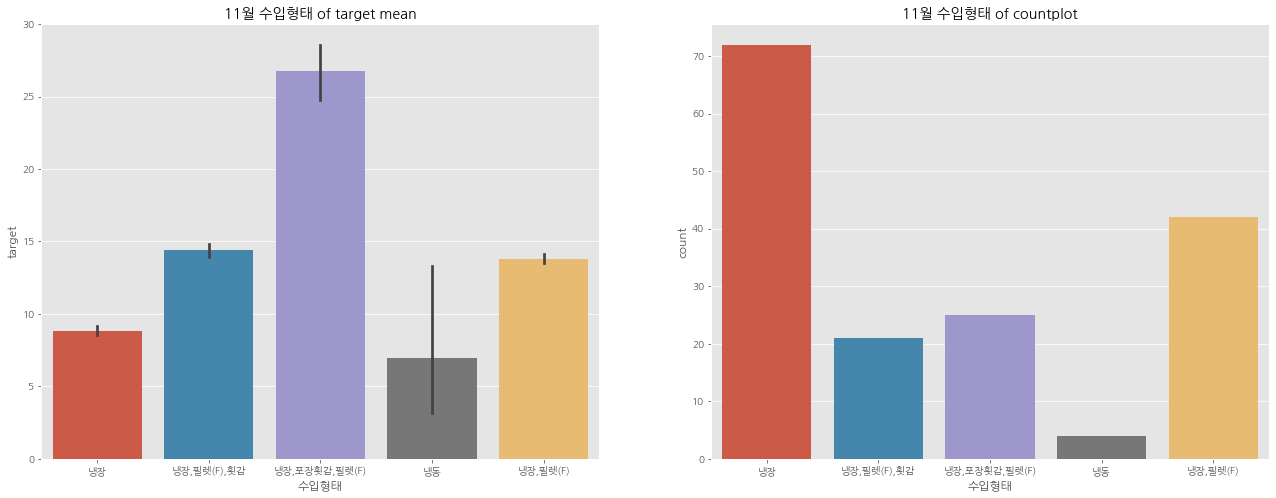

In [121]:
# month별 수입형태 확인해보기
for i in df['month'].unique():
  fig, ax = plt.subplots(ncols = 2,figsize = (22,8))
  sns.barplot(data = df[df['month'] == i], x = '수입형태', y = 'target', ax = ax[0])
  sns.countplot(df[df['month'] == i]['수입형태'], ax = ax[1])
  ax[0].set_title(f'{i}월 수입형태 of target mean')
  ax[1].set_title(f'{i}월 수입형태 of countplot')
  plt.show()

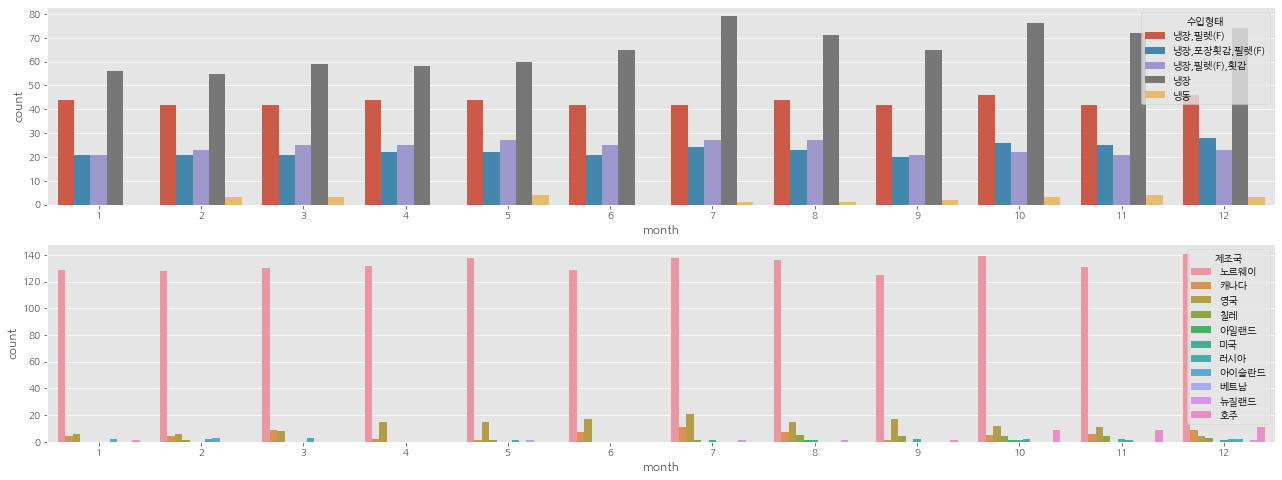

In [122]:
# 그래프를 그려보면서 month별로 수입형태, 제조국에 차이가 있는지 확인한다.
fig, ax = plt.subplots(nrows = 2, figsize = (22,8))
sns.countplot(data = df, x = 'month', hue = '수입형태', ax = ax[0])
sns.countplot(data = df, x = 'month', hue = '제조국', ax = ax[1])

In [123]:
# # 제조국을 노르웨이 and 영국 and 그 이외의 국가
# df['제조국'] = df['제조국'].apply(lambda x:x if ((x == '노르웨이')|(x == '영국')) else '그 이외의 국가')
# train['제조국'] = train['제조국'].apply(lambda x:x if ((x == '노르웨이')|(x == '영국')) else '그 이외의 국가')
# val['제조국'] = val['제조국'].apply(lambda x:x if ((x == '노르웨이')|(x == '영국')) else '그 이외의 국가')

# 제조국을 노르웨이 and 그 이외의 국가 (노르웨이만 변수로 넣어줄 때 더 좋은 성과를 냈다.)
df['제조국'] = df['제조국'].apply(lambda x:x if (x == '노르웨이') else '그 이외의 국가')
train['제조국'] = train['제조국'].apply(lambda x:x if (x == '노르웨이') else '그 이외의 국가')
val['제조국'] = val['제조국'].apply(lambda x:x if (x == '노르웨이') else '그 이외의 국가')

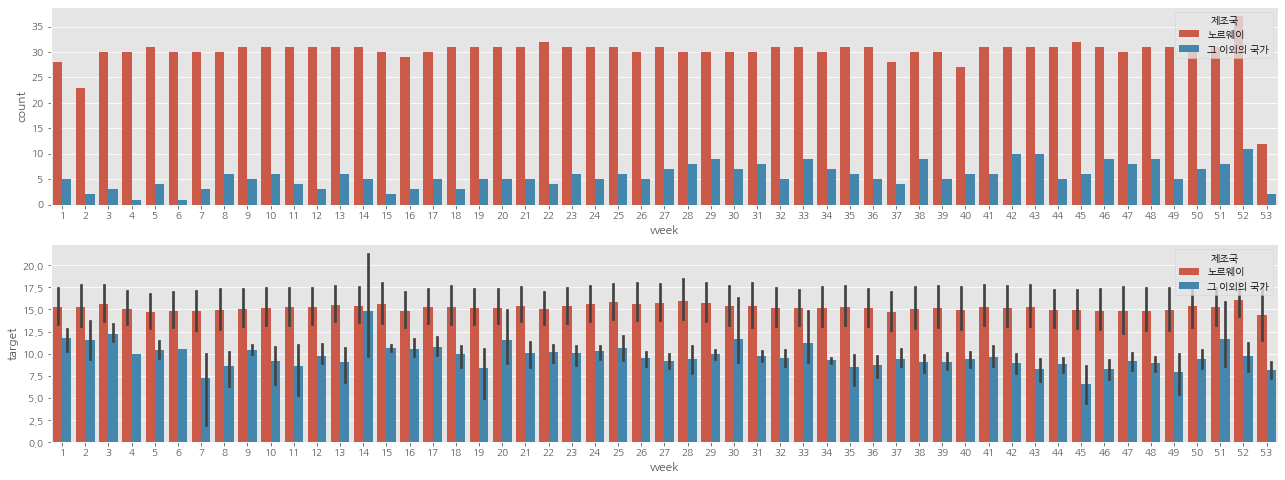

In [124]:
# week VS 제조국
fig, ax = plt.subplots(nrows = 2, figsize = (22,8))
sns.countplot(data = df, x = 'week', hue = '제조국', ax = ax[0])
sns.barplot(data =df, x = 'week', y = 'target', hue = '제조국', ax = ax[1])

In [125]:
# # 제조국을 week과 합쳐주기 위해서 데이터를 만들어 준다. (영국)
# 제조국_df = pd.get_dummies(df, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','제조국_영국','week']]
# 제조국_df = 제조국_df.groupby('week').mean().reset_index()

# 제조국_train = pd.get_dummies(train, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','제조국_영국','week']]

# 제조국_train = 제조국_train.groupby('week').mean().reset_index()


# 제조국을 week과 합쳐주기 위해서 데이터를 만들어 준다. (영국 X)
제조국_df = pd.get_dummies(df, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','week']]
제조국_df = 제조국_df.groupby('week').mean().reset_index()

제조국_train = pd.get_dummies(train, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','week']]

제조국_train = 제조국_train.groupby('week').mean().reset_index()

In [126]:
# 수입형태의 빈도수를 계산한다.
수입형태_df_mean = df.groupby('week').mean()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()
수입형태_df_std = df.groupby('week').std()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()

# train 데이터 해주기
수입형태_train_mean = train.groupby('week').mean()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()
수입형태_train_std = train.groupby('week').std()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()

In [127]:
# 외화획득용 제품이라 되어있는 부분을 외화획득용 원료로 바꿔준다.
df['수입용도'] = df['수입용도'].apply(lambda x:'외화획득용 원료' if x == '외화획득용 제품' else x)

# 수입용도로 데이터를 살펴보기로 하자.
수입용도_df = pd.get_dummies(data = df, columns = ['수입용도']).reset_index()[['기준일','week','수입용도_판매용','수입용도_자사제품제조용','수입용도_외화획득용 원료']]
수입용도_df = 수입용도_df.groupby('week').mean().reset_index()
수입용도_df

############ train #########################
# 외화획득용 제품이라 되어있는 부분을 외화획득용 원료로 바꿔준다.
train['수입용도'] = train['수입용도'].apply(lambda x:'외화획득용 원료' if x == '외화획득용 제품' else x)

# 수입용도로 데이터를 살펴보기로 하자.
수입용도_train = pd.get_dummies(data = train, columns = ['수입용도']).reset_index()[['기준일','week','수입용도_판매용','수입용도_자사제품제조용','수입용도_외화획득용 원료']]
수입용도_train = 수입용도_train.groupby('week').mean().reset_index()
수입용도_train

,week,수입용도_판매용,수입용도_자사제품제조용,수입용도_외화획득용 원료
0,1,0.696970,0.303030,0.000000
1,2,0.631579,0.368421,0.000000
2,3,0.680000,0.320000,0.000000
3,4,0.680000,0.320000,0.000000
4,5,0.666667,0.333333,0.000000
5,6,0.666667,0.333333,0.000000
6,7,0.653846,0.307692,0.038462
7,8,0.689655,0.275862,0.034483
8,9,0.689655,0.310345,0.000000
9,10,0.677419,0.290323,0.032258


## 환율

In [128]:
def load_currency(PATH, country = None):
    
    # 경로를 입력해주면 해당 경로에 저장된 환율 데이터 불러오기
    currency_data = pd.read_csv(PATH)

    # Date 변수가 문자형 타입으로 저장되어 있기 때문에, 날짜형으로 변환
    currency_data['Date'] = pd.to_datetime(currency_data['Date'])

    # 날짜를 기준으로 하여 오름차순으로 정렬해주도록 한다.
    currency_data = currency_data.sort_values(by = 'Date', ignore_index = True)

    # 한 주마다 환율의 평균을 구해줘야 하기 때문에 '기준일'을 나타내는 변수를 생성해주도록 한다.
    currency_data['기준일'] = np.repeat(pd.date_range(start = '2015-12-28', end = '2021-07-04', freq = '7D'), 7)

    # 기준일 변수를 기준으로 하여 한 주의 평균 환율을 구해주도록 한다.
    return_data = pd.pivot_table(currency_data, index = '기준일', values = country).reset_index()

    return return_data

In [129]:
환율데이터 = load_currency('/content/drive/MyDrive/빅콘테스트/환율데이터.csv',country = ['노르웨이','대한민국'])
환율데이터

,기준일,노르웨이,대한민국
0,2015-12-28,8.797391,1182.143143
1,2016-01-04,8.888908,1202.685571
2,2016-01-11,8.844832,1217.597714
3,2016-01-18,8.794476,1202.050571
4,2016-01-25,8.682488,1211.344429
...,...,...,...
283,2021-05-31,8.317809,1109.764286
284,2021-06-07,8.298362,1114.390000
285,2021-06-14,8.522072,1128.655714
286,2021-06-21,8.520960,1129.180000


Text(0.5, 0, '')

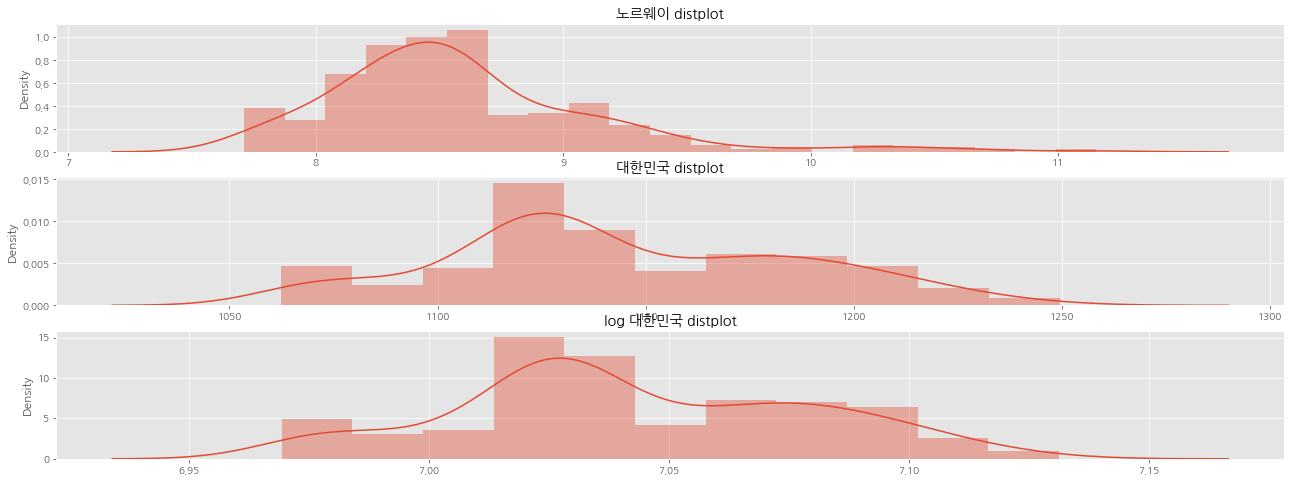

In [130]:
# 환율데이터가 얼마나 데이터와 맞게 따라가는지 확인해 보자
fig, ax = plt.subplots(nrows = 3, figsize = (22,8))
sns.distplot(환율데이터['노르웨이'], ax = ax[0])
sns.distplot(환율데이터['대한민국'], ax = ax[1])
sns.distplot(환율데이터['대한민국'].apply(lambda x: np.log1p(x)), ax = ax[2])

ax[0].set_title('노르웨이 distplot')
ax[1].set_title('대한민국 distplot')
ax[2].set_title('log 대한민국 distplot')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

In [131]:
# 환율데이터 train_val에만 사용할 데이터를 가져온다.
train_val_환율 = 환율데이터[환율데이터['기준일'] < '2021'].reset_index()

train_환율 = 환율데이터[(환율데이터['기준일'] >= '2015-12-28') & (환율데이터['기준일'] < '2020')]
val_환율 = 환율데이터[(환율데이터['기준일'] >= '2020') & (환율데이터['기준일'] < '2021')].reset_index(drop = True)
test_환율 = 환율데이터[환율데이터['기준일'] >= '2021'].reset_index(drop = True)

## 유가 주식 데이터

In [132]:
!pip install yfinance

In [133]:
import yfinance as yf

# oil 데이터를 받아준다.
oil_df = yf.download('WTI',start = '2015-12-25', end = '2021-07-04')
oil_df = oil_df.reset_index()

# oil_df를 시간별 데이터로 나눠준다.
oil_df['week'] = oil_df['Date'].dt.week
oil_df['month'] = oil_df['Date'].dt.month
oil_df['year'] = oil_df['Date'].dt.year
oil_df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,week,month,year
0,2015-12-28,2.57,2.57,2.35,2.37,2.37,785900,53,12,2015
1,2015-12-29,2.49,2.52,2.35,2.36,2.36,1227500,53,12,2015
2,2015-12-30,2.23,2.30,2.15,2.22,2.22,982900,53,12,2015
3,2015-12-31,2.23,2.36,2.15,2.31,2.31,1401300,53,12,2015
4,2016-01-04,2.44,2.56,2.27,2.37,2.37,1947800,1,1,2016
...,...,...,...,...,...,...,...,...,...,...
1384,2021-06-28,4.95,4.97,4.61,4.72,4.72,3481000,26,6,2021
1385,2021-06-29,4.71,4.84,4.71,4.71,4.71,2004200,26,6,2021
1386,2021-06-30,4.75,4.86,4.72,4.85,4.85,1899300,26,6,2021
1387,2021-07-01,4.98,5.14,4.95,5.07,5.07,4816900,26,7,2021


In [134]:
# 전체 시간 데이터를 얻기 위해서 timedelta를 사용하여 리스트를 만들어 준다.
from datetime import timedelta

start = '2015-12-28'

time_list = []
start = pd.to_datetime(start)
for i in range(2016):
  start = pd.to_datetime(start)
  start = start.strftime('%Y-%m-%d')
  time_list.append(start)

  start = pd.to_datetime(start)
  start = start + timedelta(days = 1) 

In [135]:
# 시간을 7일씩 잘라서 week 데이터로 만들어 준다.
final_oil = pd.DataFrame(time_list, columns = ['Date'])
final_oil['Date'] = pd.to_datetime(final_oil['Date'])
final_oil = pd.merge(final_oil, oil_df, how  = 'left', on = 'Date')

final_oil['기준일'] = np.repeat(pd.date_range(start = '2015-12-28', end = '2021-07-03', freq = '7D'), 7)

final_oil = pd.pivot_table(final_oil, index = '기준일', aggfunc = 'mean').reset_index()

In [136]:
# 데이터를 넣기 편하게 넣기 위해서 기준일 별로 나눠준다.
train_oil = final_oil[final_oil['기준일'] <= '2020']['Close']
val_oil = final_oil[(final_oil['기준일'] <= '2021') & (final_oil['기준일']>= '2020')].reset_index(drop = True)['Close']
test_oil = final_oil[final_oil['기준일'] >= '2021'].reset_index(drop = True)['Close']
df_oil = final_oil[final_oil['기준일'] <= '2021']['Close']

# Modeling

## train VS val

In [137]:
############################## train_data 생성 #####################################################
train_data = train.groupby('기준일').mean().reset_index()[['기준일','target','month','week']]
# 원래는 노르웨이 환율과 대한민국 환율을 전부 넣을려고 했지만 노르웨이 환율을 뺏을 때 더 좋은 rmse가 나오기 때문에 제거하도록 한다.
train_data = pd.concat([train_data, train_환율['대한민국']], axis = 1)

train_data = pd.merge(train_data, 수입형태_train_mean, how = 'left', on = 'week')

train_data = pd.merge(train_data, 제조국_train, how = 'left', on = 'week')

train_data = pd.merge(train_data, 수입용도_train, how = 'left', on = 'week')

train_data = pd.concat([train_data,train_oil], axis = 1)

train_data.drop(['month','week'], axis = 1, inplace = True)

train_data['대한민국'] = train_data['대한민국'].apply(lambda x:np.log1p(x))

############################# val_data 생성 #########################################################
val_data = val.groupby('기준일').mean().reset_index()[['기준일','target','month','week']]

# 원래는 노르웨이 환율과 대한민국 환율을 전부 넣을려고 했지만 노르웨이 환율을 뺏을 때 더 좋은 rmse가 나오기 때문에 제거하도록 한다.
val_data = pd.concat([val_data, val_환율[['대한민국']]], axis = 1)

val_data = pd.merge(val_data, 수입형태_train_mean, how = 'left', on = 'week')

val_data = pd.merge(val_data, 제조국_train, how = 'left', on = 'week')

val_data = pd.merge(val_data, 수입용도_train, how = 'left', on = 'week')

val_data = pd.concat([val_data,val_oil], axis = 1)

val_data.drop(['month','week'], axis = 1, inplace = True)

val_data['대한민국'] = val_data['대한민국'].apply(lambda x:np.log1p(x))

# 우리는 6월까지의 데이터만 test로 놓기 때문에 정확한 분석을 위해서 6월까지의 데이터만 넣는다
val_data = val_data[val_data['기준일'] <= '2020-06-30']

In [138]:
## 전체 데이터를 가지고 test데이터 예측을 한다.
data = df.groupby('기준일').mean().reset_index()[['기준일','target','month','week']]

data = pd.concat([data, train_val_환율['대한민국']], axis = 1)

data = pd.merge(data, 수입형태_df_mean ,how ='left', on = 'week')

data = pd.merge(data, 제조국_df, how = 'left', on = 'week')

data = pd.merge(data, 수입용도_df, how = 'left', on = 'week')

data = pd.concat([data, df_oil], axis = 1)

data.drop(['month','week'], axis = 1, inplace = True)

data['대한민국'] = data['대한민국'].apply(lambda x: np.log1p(x))

######################### test_data ########################################
test_data = test[['일자.1']]
test_data = test_data.rename(columns = {'일자.1':'기준일'})

test_data['week'] = test_data['기준일'].dt.week

test_data = pd.concat([test_data, test_환율['대한민국']], axis = 1)

test_data = pd.merge(test_data, 수입형태_df_mean, how = 'left', on = 'week')

test_data = pd.merge(test_data, 제조국_df, how = 'left', on = 'week')

test_data = pd.merge(test_data, 수입용도_df, how = 'left', on = 'week')

test_data = pd.concat([test_data, test_oil], axis = 1)

test_data.drop(['week'], axis = 1, inplace = True)

test_data['대한민국'] = test_data['대한민국'].apply(lambda x: np.log1p(x))

In [139]:
!pip install catboost

In [140]:
!pip install vecstack

[13:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
***************************lightgbm의 그래프**************************


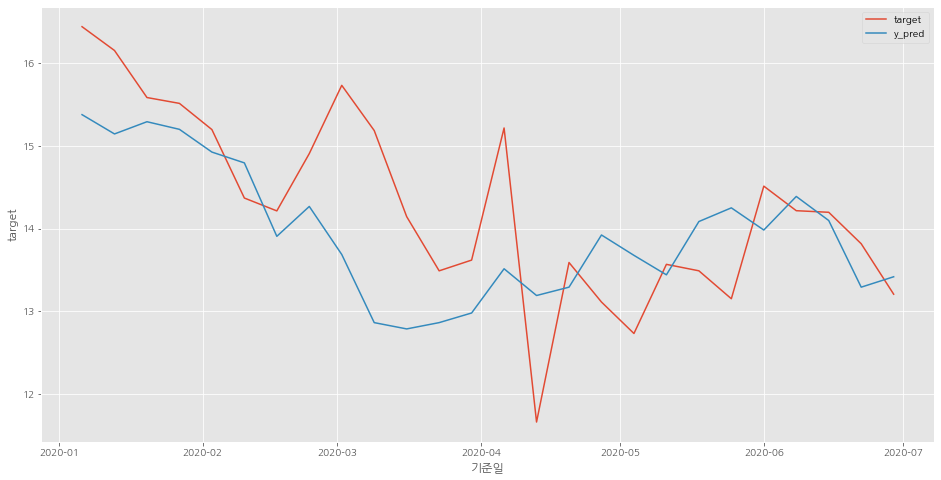

lightgbm의 RMSE : 0.970284706192697
lightgbm의 r^2 score : 0.24822920693104744
***************************xgboost의 그래프**************************


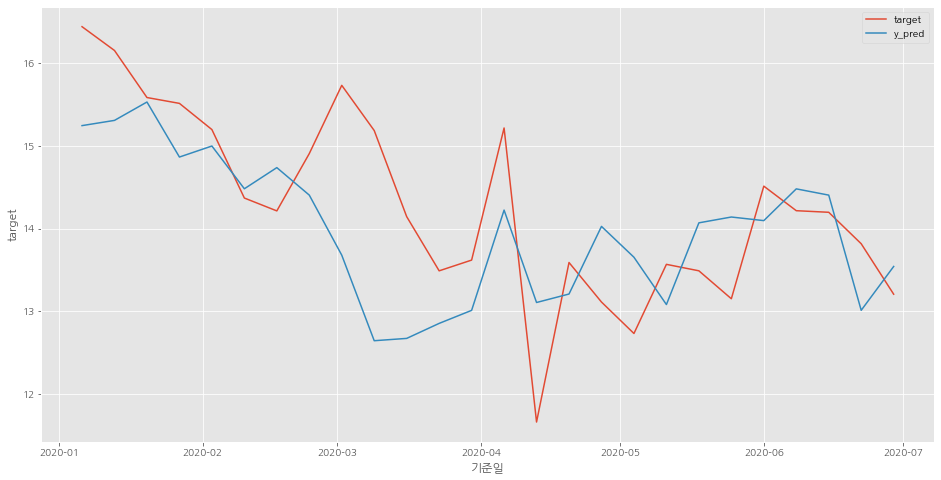

xgboost의 RMSE : 0.9673998161446212
xgboost의 r^2 score : 0.25269295230146505
***************************catboost의 그래프**************************


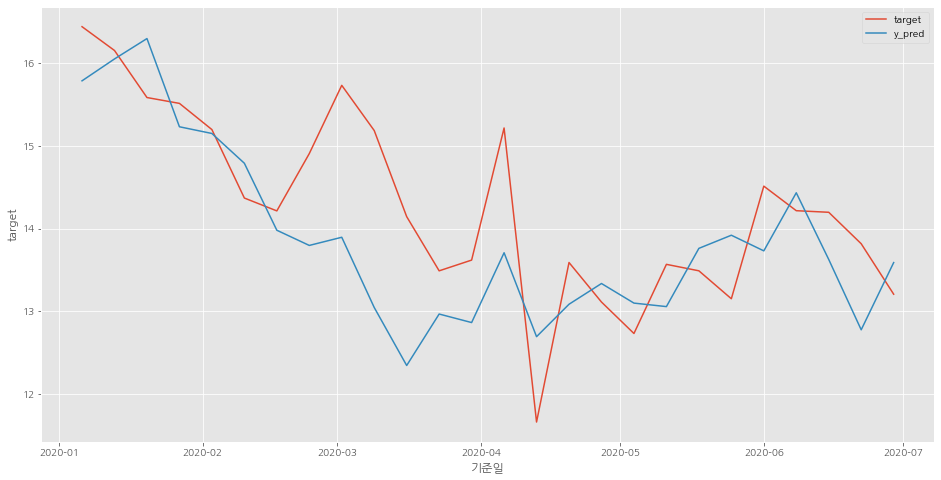

catboost의 RMSE : 0.9095047527691965
catboost의 r^2 score : 0.3394631929987342
***************************lr의 그래프**************************


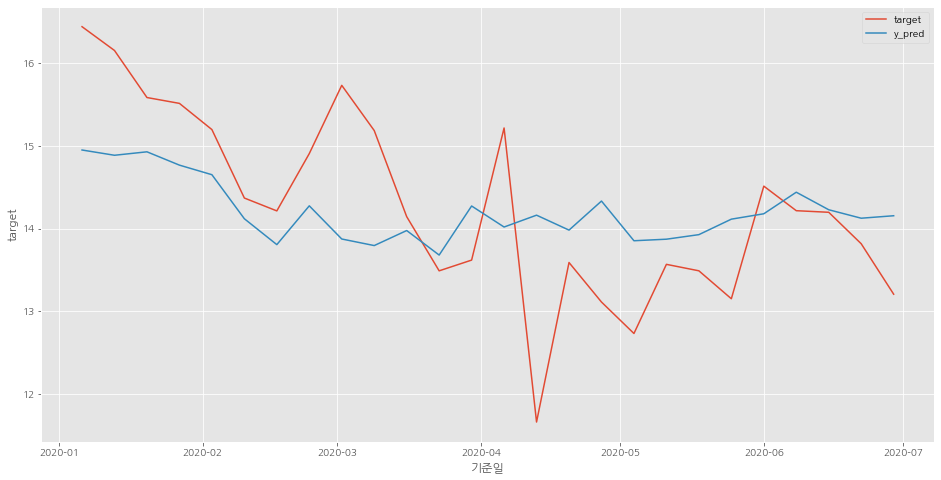

lr의 RMSE : 0.9736604715065655
lr의 r^2 score : 0.2429890615457565
***************************ridge의 그래프**************************


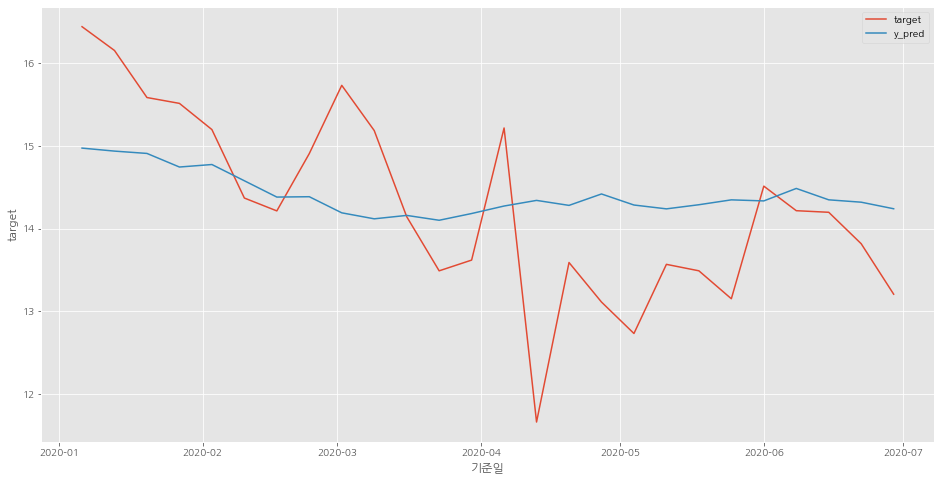

ridge의 RMSE : 1.0023110690576444
ridge의 r^2 score : 0.19778250301144618
***************************lasso의 그래프**************************


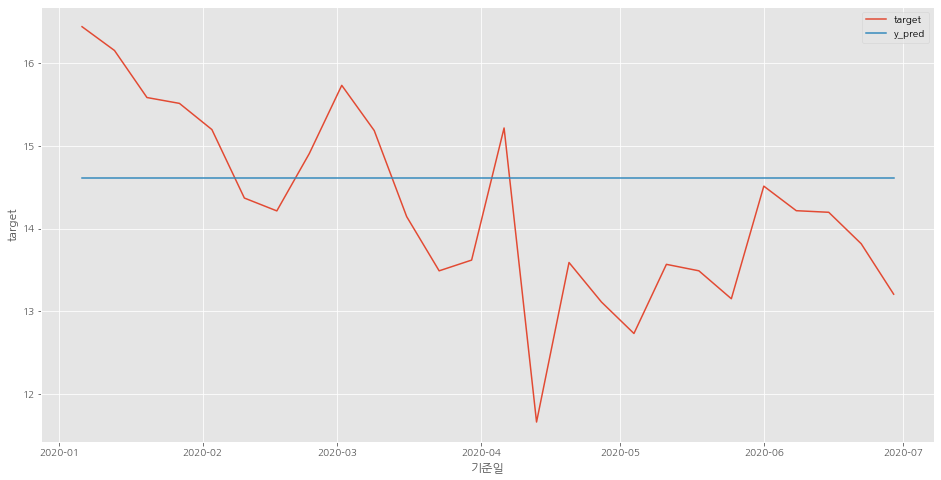

lasso의 RMSE : 1.1684590903194525
lasso의 r^2 score : -0.09021988799398373
***************************rfg의 그래프**************************


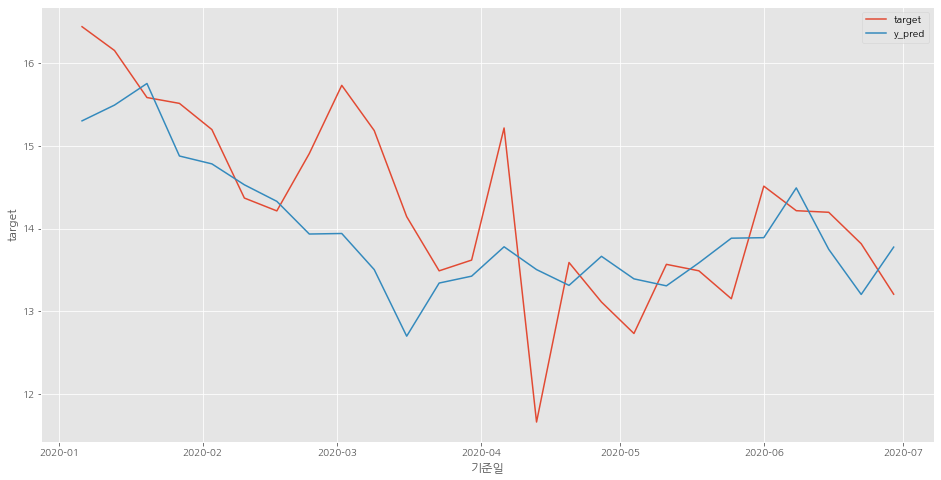

rfg의 RMSE : 0.8730778825353291
rfg의 r^2 score : 0.39131436857622703
***************************gb의 그래프**************************


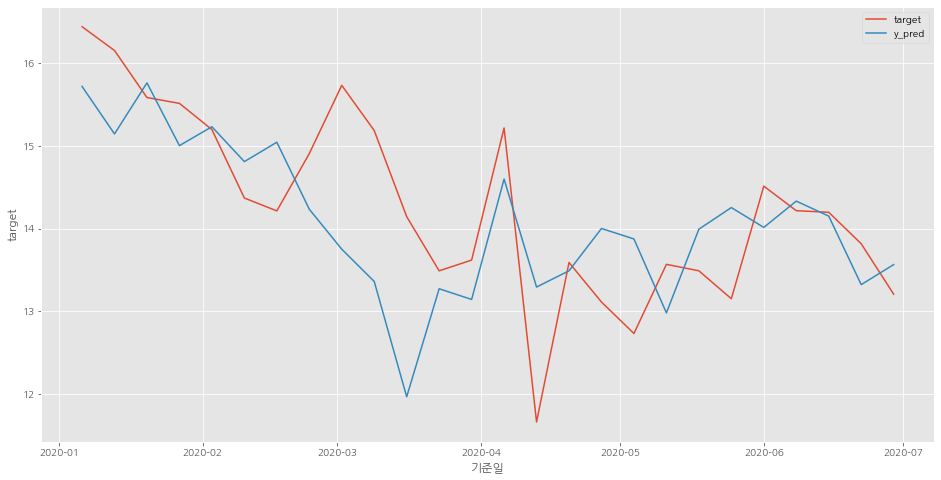

gb의 RMSE : 0.9427365349387664
gb의 r^2 score : 0.2903115239131937


In [141]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from vecstack import stacking

def run_model(train_data = None, val_data = None):

  train_data = train_data.reset_index(drop = True)
  val_data = val_data.reset_index(drop = True)

  X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
  X_test, y_test = val_data.drop(['기준일','target'], axis = 1), val_data['target']

  models = {'lightgbm':LGBMRegressor(random_state = 42), 'xgboost':XGBRegressor(random_state = 42),'catboost': CatBoostRegressor(random_state = 42, verbose = False),'lr': LinearRegression(),
            'ridge': Ridge(random_state = 42),'lasso': Lasso(),'rfg':RandomForestRegressor(random_state = 42),'gb':GradientBoostingRegressor(random_state = 42)}


  final_y_pred = {}
  for i, j in models.items():
    model = j
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred = pd.Series(y_pred)

    validation_data = pd.concat([val_data[['기준일','target']],y_pred], axis = 1).rename(columns = {0 : 'y_pred'}).groupby('기준일').mean()

    final_y_pred[i] = validation_data

  for i, j in final_y_pred.items():
    print(f'***************************{i}의 그래프**************************')

    plt.figure(figsize = (16,8))
    sns.lineplot(data =j , x = '기준일', y = 'target')
    sns.lineplot(data =j, x = '기준일', y = 'y_pred')
    plt.legend(labels = ['target','y_pred'])
    plt.show()

    print(f'{i}의 RMSE :', mean_squared_error(j['target'], j['y_pred']) ** 0.5)
    print(f'{i}의 r^2 score :', r2_score(j['target'], j['y_pred']))

run_model(train_data = train_data, val_data = val_data)

- 잘 나오는 모델로는 randomforest와 catboost이다.

In [142]:
# Stacking Ensemble
def rmse(y, y_pred):

  return np.sqrt(mean_squared_error(y, y_pred))

lgb = LGBMRegressor(random_state =42)
xgb = XGBRegressor(random_state = 42, tree_method = 'gpu_hist')
catboost = CatBoostRegressor(random_state =42, task_type = 'GPU', verbose = False)
rfg = RandomForestRegressor(random_state = 42)
# ridge = Ridge(random_state = 42)
lr = LinearRegression()
gb = GradientBoostingRegressor(random_state = 42)
# lasso = Lasso(random_state = 42)

X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
X_test, y_test = val_data.drop(['기준일','target'], axis = 1), val_data['target']

models = [lgb,xgb, catboost, rfg,lr, gb]

S_train, S_test = stacking(models, X_train, y_train, X_test, regression = True, mode = 'oof_pred_bag', metric  = rmse, n_folds =3, random_state = 42)

lgb = LinearRegression()
lgb.fit(S_train, y_train)
y_pred = lgb.predict(S_test)
RMSE = mean_squared_error(y_test, y_pred) **0.5

print('R^2 score :',r2_score(y_test, y_pred))
print('rmse score :',RMSE)

[13:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score : -0.035644018799046995
rmse score : 1.1388373764093052


In [143]:
# Voting Ensemble
from sklearn.ensemble import VotingRegressor

lr = LinearRegression()
lgb = LGBMRegressor(random_state = 42)
cat = CatBoostRegressor(random_state = 42,verbose = False, task_type = 'GPU')
xgb = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
# ridge = Ridge(random_state = 42)
rfg = RandomForestRegressor(random_state = 42)
gb = GradientBoostingRegressor(random_state = 42)


vo_reg = VotingRegressor(estimators = [('lr',lr),('lgb',lgb),('cat',cat),('xgb',xgb),('rfg',rfg),('gb',gb)])
vo_reg.fit(X_train, y_train)
y_pred = vo_reg.predict(X_test)

RMSE = rmse(y_test, y_pred)

print('R^2 score :',r2_score(y_test, y_pred))
print('rmse score :',RMSE)

[13:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score : 0.32828618087353834
rmse score : 0.917167386028241


### Moving average 추가

In [144]:
target = val.groupby('기준일')['target'].mean().reset_index()[:26]
val_data['target'] = y_pred

In [145]:
final_train = pd.concat([train_data, val_data], axis = 0)
final_train['moving_average'] = final_train['target'].rolling(5).mean()
final_train = final_train.dropna()

[13:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
***************************lightgbm의 그래프**************************


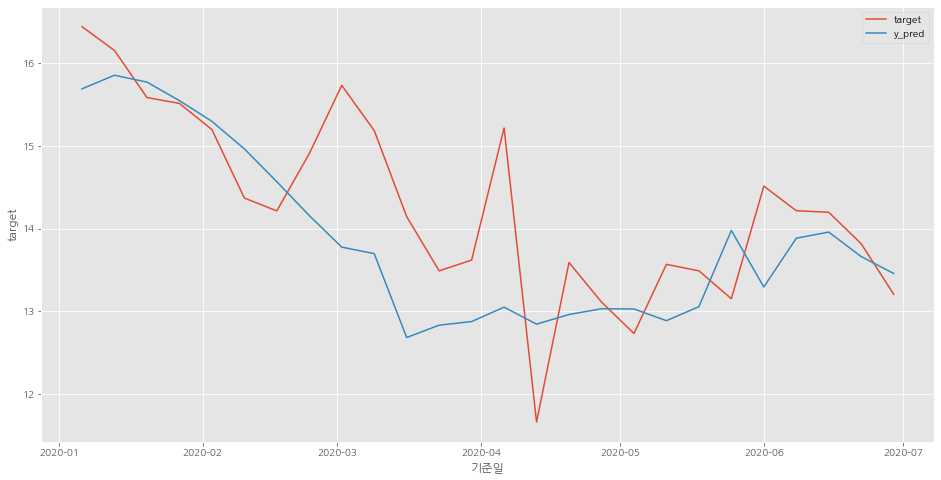

lightgbm의 RMSE : 0.890560249752101
lightgbm의 r^2 score : 0.3666938727048086
***************************xgboost의 그래프**************************


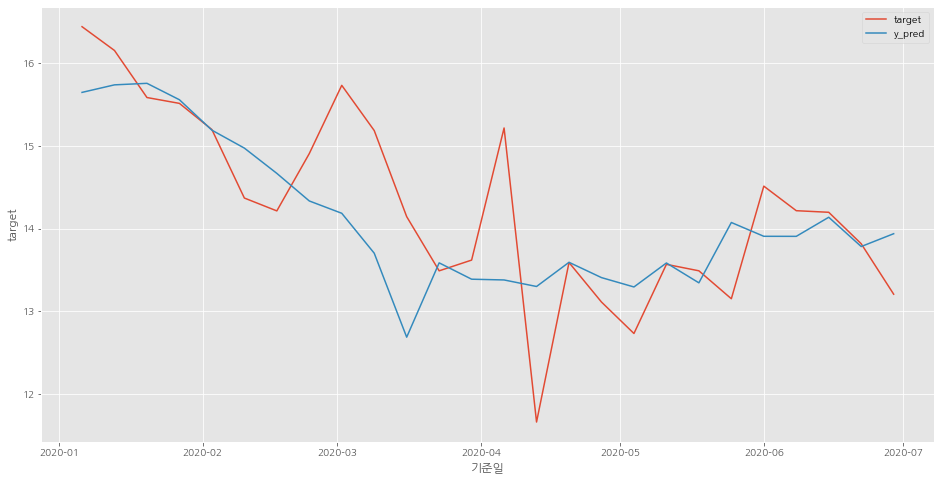

xgboost의 RMSE : 0.8062510769086251
xgboost의 r^2 score : 0.480927892629736
***************************catboost의 그래프**************************


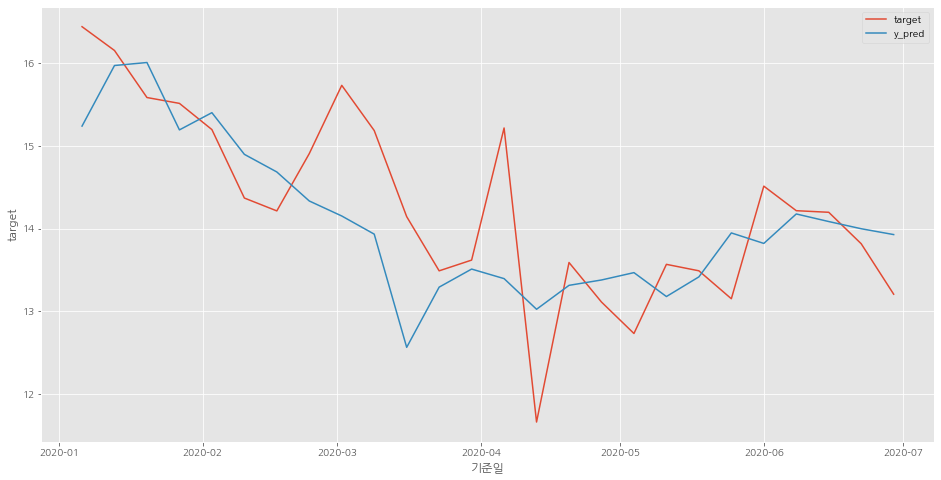

catboost의 RMSE : 0.808422017164466
catboost의 r^2 score : 0.4781287852621492
***************************lr의 그래프**************************


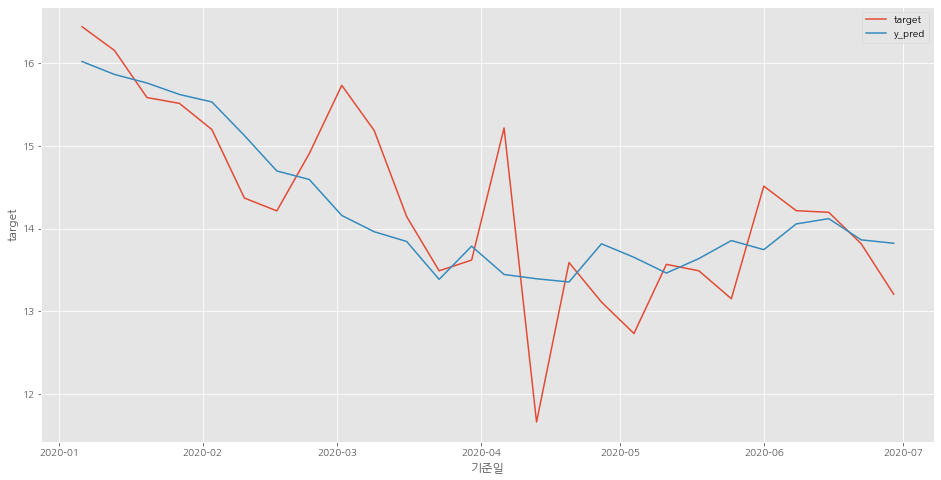

lr의 RMSE : 0.7475453157160155
lr의 r^2 score : 0.5537665462316018
***************************ridge의 그래프**************************


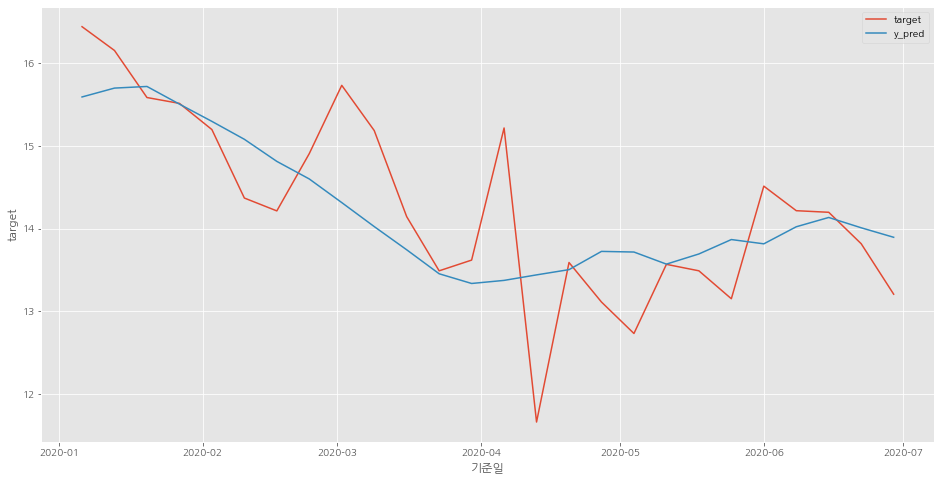

ridge의 RMSE : 0.7611156702102907
ridge의 r^2 score : 0.537418346712909
***************************lasso의 그래프**************************


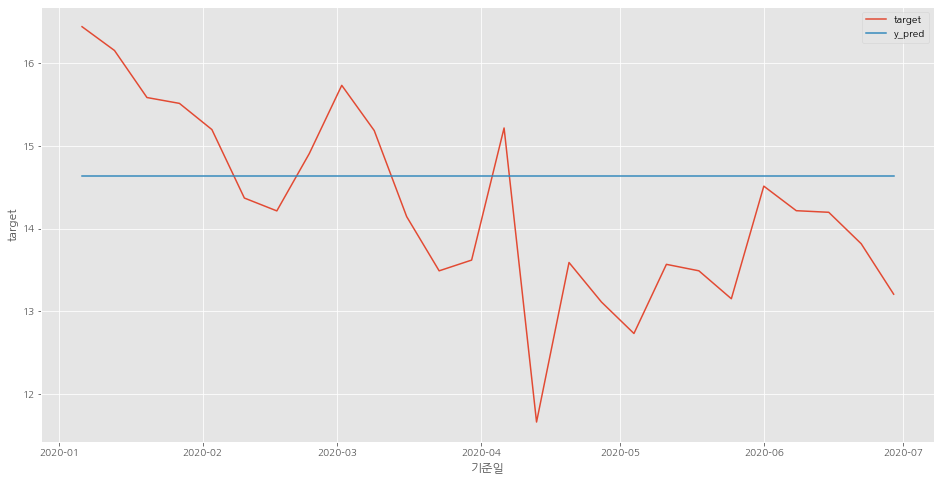

lasso의 RMSE : 1.1769959677603394
lasso의 r^2 score : -0.10620859113961889
***************************rfg의 그래프**************************


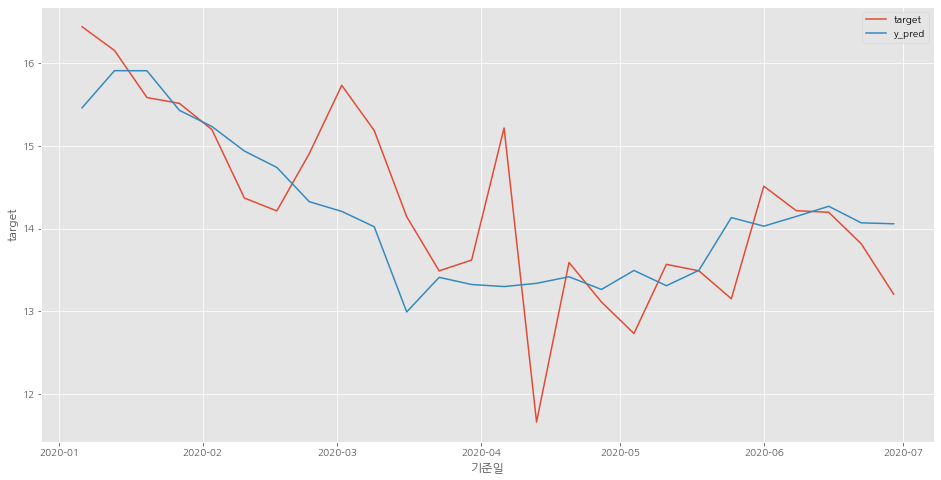

rfg의 RMSE : 0.7942394537876125
rfg의 r^2 score : 0.496279076842164
***************************gb의 그래프**************************


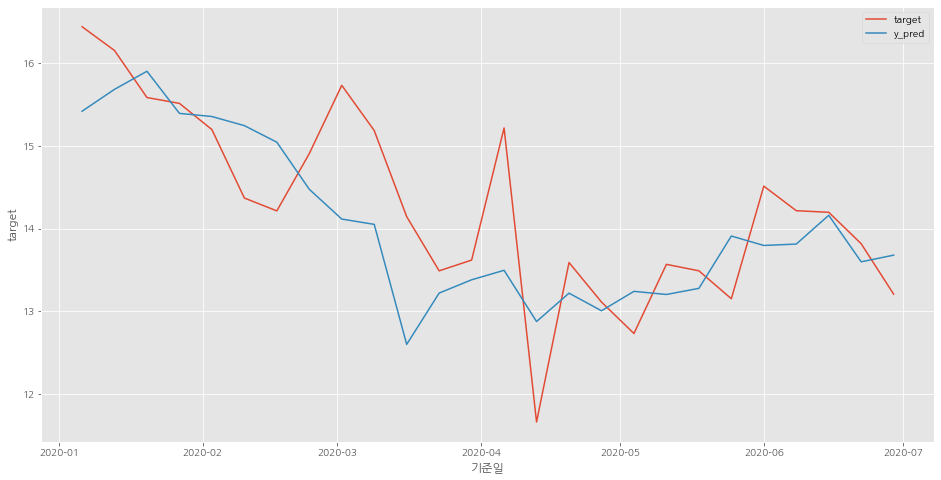

gb의 RMSE : 0.7858719570778995
gb의 r^2 score : 0.5068368016231793


In [146]:
train_data = final_train[final_train['기준일'] < '2020']
val_data = final_train[final_train['기준일'] >= '2020']


train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)

X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
X_test, y_test = val_data.drop(['기준일','target'], axis = 1), val_data['target']

models = {'lightgbm':LGBMRegressor(random_state = 42), 'xgboost':XGBRegressor(random_state = 42),'catboost': CatBoostRegressor(random_state = 42, verbose = False),'lr': LinearRegression(),
            'ridge': Ridge(random_state = 42),'lasso': Lasso(),'rfg':RandomForestRegressor(random_state = 42),'gb':GradientBoostingRegressor(random_state = 42)}


final_y_pred = {}
for i, j in models.items():
  model = j
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  y_pred = pd.Series(y_pred)

  validation_data = pd.concat([val_data[['기준일','target']],y_pred], axis = 1).rename(columns = {0 : 'y_pred'}).groupby('기준일').mean()

  final_y_pred[i] = validation_data

for i, j in final_y_pred.items():
  print(f'***************************{i}의 그래프**************************')

  plt.figure(figsize = (16,8))
  sns.lineplot(data =target , x = '기준일', y = 'target')
  sns.lineplot(data =j, x = '기준일', y = 'y_pred')
  plt.legend(labels = ['target','y_pred'])
  plt.show()

  print(f'{i}의 RMSE :', mean_squared_error(target['target'], j['y_pred']) ** 0.5)
  print(f'{i}의 r^2 score :', r2_score(target['target'], j['y_pred']))

In [147]:
#### stacking
lgb = LGBMRegressor(random_state =42)
xgb = XGBRegressor(random_state = 42, tree_method = 'gpu_hist')
catboost = CatBoostRegressor(random_state =42, task_type = 'GPU', verbose = False)
rfg = RandomForestRegressor(random_state = 42)
# ridge = Ridge(random_state = 42)
lr = LinearRegression()
gb = GradientBoostingRegressor(random_state = 42)
# lasso = Lasso(random_state = 42)

X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
X_test, y_test = val_data.drop(['기준일','target'], axis = 1), val_data['target']

models = [lgb,xgb, catboost,rfg,lr, gb]

S_train, S_test = stacking(models, X_train, y_train, X_test, regression = True, mode = 'oof_pred_bag', metric  = rmse, n_folds =3, random_state = 42)

lgb = LinearRegression()
lgb.fit(S_train, y_train)
y_pred = lgb.predict(S_test)
RMSE = mean_squared_error(target['target'], y_pred) **0.5

print('R^2 score :',r2_score(target['target'], y_pred))
print('rmse score :',RMSE)

[13:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score : 0.5455045311349688
rmse score : 0.7544339790682372


In [148]:
# 이번에 사용할 모델은 voting을 사용한다.
lr = LinearRegression()
lgb = LGBMRegressor(random_state = 42)
cat = CatBoostRegressor(random_state = 42,verbose = False, task_type = 'GPU')
xgb = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
# ridge = Ridge(random_state = 42)
rfg = RandomForestRegressor(random_state = 42)
gb = GradientBoostingRegressor(random_state = 42)


vo_reg = VotingRegressor(estimators = [('lr',lr),('lgb',lgb),('cat',cat),('xgb',xgb),('rfg',rfg),('gb',gb)])
vo_reg.fit(X_train, y_train)
y_pred = vo_reg.predict(X_test)

RMSE = rmse(target['target'], y_pred)

print('R^2 score :',r2_score(target['target'], y_pred))
print('rmse score :',RMSE)

[13:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score : 0.5097145187507586
rmse score : 0.7835757334612969


In [149]:
import statsmodels.api as sm

X = sm.add_constant(train_data.drop(['기준일','target'],axis = 1))
y = train_data['target']

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     28.48
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           3.99e-33
Time:                        13:40:27   Log-Likelihood:                -198.94
No. Observations:                 206   AIC:                             419.9
Df Residuals:                     195   BIC:                             456.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2881      5.897     -0.

## 실제 데이터 예측을 진행해 보자.

In [150]:
# 실제 Test 데이터를 예측할 때 필요한 함수를 작성한다.
def run_submit_model(train_data = None, test_data =  None):
  train_data = train_data.reset_index(drop = True)
  test_data = test_data.reset_index(drop = True)

  # train과 test데이터를 X_train,y_train,X_test 로 나눠준다.
  X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
  X_test = test_data.drop(['기준일'],axis = 1)

  # 위의 모델중에 가장 잘 나온 randomforest를 가지고 모델을 돌려준다.
  lr = LinearRegression()
  lgb = LGBMRegressor(random_state = 42)
  cat = CatBoostRegressor(random_state = 42,verbose = False, task_type = 'GPU')
  xgb = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
  ridge = Ridge(random_state = 42)
  rfg = RandomForestRegressor(random_state = 42)
  gb = GradientBoostingRegressor(random_state = 42)
  print(X_train.columns)
  print(X_test.columns)


  vo_reg = VotingRegressor(estimators = [('lr',lr),('lgb',lgb),('cat',cat),('xgb',xgb),('ridge',ridge),('rfg',rfg),('gb',gb)])
  vo_reg.fit(X_train, y_train)
  y_pred = vo_reg.predict(X_test)

  return y_pred

y_pred = run_submit_model(train_data = data, test_data = test_data)

Index(['대한민국', '냉장', '필렛(F)', '횟감', '포장횟감', '냉동', '제조국_노르웨이', '수입용도_판매용',
       '수입용도_자사제품제조용', '수입용도_외화획득용 원료', 'Close'],
      dtype='object')
Index(['대한민국', '냉장', '필렛(F)', '횟감', '포장횟감', '냉동', '제조국_노르웨이', '수입용도_판매용',
       '수입용도_자사제품제조용', '수입용도_외화획득용 원료', 'Close'],
      dtype='object')
[13:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Moving average 적용

In [151]:
test_data['target'] = y_pred

final_data = pd.concat([data, test_data], axis = 0)

final_data['moving_average'] = final_data['target'].rolling(5).mean()

train_data = final_data[final_data['기준일'] < '2021']

test_data = final_data[final_data['기준일'] > '2021']

train_data = train_data.reset_index(drop = True)
train_data = train_data.dropna()
test_data = test_data.reset_index(drop = True)
test_data.drop('target', axis = 1, inplace = True)

In [152]:
y_pred = run_submit_model(train_data = train_data, test_data = test_data)

Index(['대한민국', '냉장', '필렛(F)', '횟감', '포장횟감', '냉동', '제조국_노르웨이', '수입용도_판매용',
       '수입용도_자사제품제조용', '수입용도_외화획득용 원료', 'Close', 'moving_average'],
      dtype='object')
Index(['대한민국', '냉장', '필렛(F)', '횟감', '포장횟감', '냉동', '제조국_노르웨이', '수입용도_판매용',
       '수입용도_자사제품제조용', '수입용도_외화획득용 원료', 'Close', 'moving_average'],
      dtype='object')
[13:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [153]:
test['어종.1'] = '연어'
test['상세어종.1'] = '연어'
test['예측단가($).1'] = y_pred
test

,어종,상세어종,일자,예측단가($),Unnamed: 4,어종.1,상세어종.1,일자.1,예측단가($).1,Unnamed: 9,어종.2,상세어종.2,일자.2,예측단가($).2
0,오징어,오징어,2021-01-04,NaN,NaN,연어,연어,2021-01-04,13.510794,NaN,새우,흰다리새우,2021-01-04,NaN
1,NaN,NaN,2021-01-11,NaN,NaN,연어,연어,2021-01-11,13.635897,NaN,NaN,NaN,2021-01-11,NaN
2,NaN,NaN,2021-01-18,NaN,NaN,연어,연어,2021-01-18,13.716596,NaN,NaN,NaN,2021-01-18,NaN
3,NaN,NaN,2021-01-25,NaN,NaN,연어,연어,2021-01-25,14.130862,NaN,NaN,NaN,2021-01-25,NaN
4,NaN,NaN,2021-02-01,NaN,NaN,연어,연어,2021-02-01,14.226407,NaN,NaN,NaN,2021-02-01,NaN
5,NaN,NaN,2021-02-08,NaN,NaN,연어,연어,2021-02-08,14.669870,NaN,NaN,NaN,2021-02-08,NaN
6,NaN,NaN,2021-02-15,NaN,NaN,연어,연어,2021-02-15,14.147751,NaN,NaN,NaN,2021-02-15,NaN
7,NaN,NaN,2021-02-22,NaN,NaN,연어,연어,2021-02-22,14.070444,NaN,NaN,NaN,2021-02-22,NaN
8,NaN,NaN,2021-03-01,NaN,NaN,연어,연어,2021-03-01,14.547937,NaN,NaN,NaN,2021-03-01,NaN
9,NaN,NaN,2021-03-08,NaN,NaN,연어,연어,2021-03-08,14.396989,NaN,NaN,NaN,2021-03-08,NaN
